
# Mantel Proximity Analysis — 感情×テキスト×空間の距離比較

このノートブックは、以下を一括で実行できるように構成しています。

1. **感情データの前処理（割合化）**：`pivot_table_id.csv`（場所×感情強度のクロス集計）を読み込み、場所ごとに合計=1 となるように正規化します。  
2. **感情距離行列の作成**：コサイン距離で 50×50 の距離行列 `D_emotion` を作成します。  
3. **空間距離行列の自動生成**：ざっくり設計したサブカテゴリにもとづいて 50×50 の `D_space` を生成します（後で調整可能）。  
4. **Mantelテスト（Pearson, permutation）**：`D_emotion` と `D_space` の相関（r）と p値を算出します。  
5. **（任意）図の出力**：距離行列のヒートマップ、セリエーション（Fiedler順）での並べ替え可視化。  
6. **（後で追加）テキスト距離**：`bert_embeddings.csv` を用意すれば同様に Mantel比較が可能です。

> 事前に `/content/pivot_table_id.csv` を置いてください（このチャットから既にアップロード済み）。  
> テキスト距離は `bert_embeddings.csv`（50×768など）を後から同ディレクトリに置けばOKです。


# 感情データの前処理（割合化）

In [ ]:
import pandas as pd
import numpy as np

# マッピング辞書
num_emotion_mapping = {
    "1-関心": ("期待", 1), "1-期待": ("期待", 2), "1-警戒": ("期待", 3),
    "2-苛立ち": ("怒り", 1), "2-怒り": ("怒り", 2), "2-激怒": ("怒り", 3),
    "3-うんざり": ("嫌悪", 1), "3-嫌悪": ("嫌悪", 2), "3-強い嫌悪": ("嫌悪", 3),
    "4-哀愁": ("悲しみ", 1), "4-悲しみ": ("悲しみ", 2), "4-悲嘆": ("悲しみ", 3),
    "5-放心": ("驚き", 1), "5-驚き": ("驚き", 2), "5-驚嘆": ("驚き", 3),
    "6-不安": ("恐れ", 1), "6-恐れ": ("恐れ", 2), "6-恐怖": ("恐れ", 3),
    "7-容認": ("信頼", 1), "7-信頼": ("信頼", 2), "7-敬愛": ("信頼", 3),
    "8-平穏": ("喜び", 1), "8-喜び": ("喜び", 2), "8-恍惚": ("喜び", 3)
}

file_paths = [
    "/content/ニッチ構築と環境選択に関する調査(1a~1j) +（回答） - フォームの回答 1.csv",
    "/content/ニッチ構築と環境選択に関する調査(2a~2j) （回答） - フォームの回答 1.csv",
    "/content/ニッチ構築と環境選択に関する調査(3a~3j) （回答） - フォームの回答 1.csv",
    "/content/ニッチ構築と環境選択に関する調査(4a~4j)  （回答） - フォームの回答 1.csv",
    "/content/ニッチ構築と環境選択に関する調査(5a~5j)  （回答） - フォームの回答 1.csv",
]

# 場所ID→設問文テキスト（Q1カラム名そのもの）辞書を作る
place_id_to_text = {}

for file_idx, path in enumerate(file_paths):
    df = pd.read_csv(path)
    for c in "abcdefghij":
        place_id = f"{file_idx+1}{c}"
        # Q1カラム名だけを厳密抽出（1つだけのはず）
        q1_col = next((col for col in df.columns if (
            col.startswith(f"{file_idx+1}{c}-Q1.") and
            ("どのような感情を抱きますか" in col)
        )), None)
        if q1_col:
            # 設問ラベルとしてcol名のうちQ1.以降の部分だけ抽出
            text = q1_col.split(". ", 1)[-1] if ". " in q1_col else q1_col
            place_id_to_text[place_id] = text


# マージ作業
merged_long = []
for file_idx, path in enumerate(file_paths):
    df = pd.read_csv(path)
    for c in "abcdefghij":
        place_id = f"{file_idx+1}{c}"
        if c in "ab": cat = "自然段階"
        elif c in "cd": cat = "第一段階"
        elif c in "ef": cat = "第二段階"
        elif c in "gh": cat = "第三段階"
        else: cat = "第四段階"
        q_cols_found = [col for col in df.columns if (
            (col.startswith(f"{file_idx+1}{c}-Q") and (
                ("どのような感情を抱きますか" in col)
            ))
        )]
        # 場所説明テキスト（設問ラベル）
        place_text = place_id_to_text.get(place_id, "")
        for idx, row in df.iterrows():
            for col in q_cols_found:
                emo_str = row[col] if col in row else np.nan
                if pd.isna(emo_str):
                    continue
                for emo in str(emo_str).split(","):
                    emo = emo.strip()
                    if emo in num_emotion_mapping:
                        base, level = num_emotion_mapping[emo]
                        merged_long.append({
                            "回答者番号": idx,
                            "場所ID": place_id,
                            "場所カテゴリ": cat,
                            "感情": emo,
                            "基本感情": base,
                            "強度": level,
                            "場所テキスト": place_text  # ここで付加
                        })

# データフレーム化
emotion_df = pd.DataFrame(merged_long)

In [ ]:
emotion_df

,回答者番号,場所ID,場所カテゴリ,感情,基本感情,強度,場所テキスト
0,0,1a,自然段階,7-敬愛,信頼,3,「北国の深い山地で、樹齢数百年のブナが天蓋のように茂る手つかずの森」に対してどのような感情を...
1,0,1a,自然段階,8-平穏,喜び,1,「北国の深い山地で、樹齢数百年のブナが天蓋のように茂る手つかずの森」に対してどのような感情を...
2,1,1a,自然段階,8-喜び,喜び,2,「北国の深い山地で、樹齢数百年のブナが天蓋のように茂る手つかずの森」に対してどのような感情を...
3,1,1a,自然段階,8-平穏,喜び,1,「北国の深い山地で、樹齢数百年のブナが天蓋のように茂る手つかずの森」に対してどのような感情を...
4,2,1a,自然段階,1-関心,期待,1,「北国の深い山地で、樹齢数百年のブナが天蓋のように茂る手つかずの森」に対してどのような感情を...
...,...,...,...,...,...,...,...
4419,27,5j,第四段階,8-平穏,喜び,1,「間伐材を発電・温室・木工に循環利用する森林バイオマスのモデルタウン」に対してどのような感情...
4420,28,5j,第四段階,1-関心,期待,1,「間伐材を発電・温室・木工に循環利用する森林バイオマスのモデルタウン」に対してどのような感情...
4421,28,5j,第四段階,7-容認,信頼,1,「間伐材を発電・温室・木工に循環利用する森林バイオマスのモデルタウン」に対してどのような感情...
4422,28,5j,第四段階,8-平穏,喜び,1,「間伐材を発電・温室・木工に循環利用する森林バイオマスのモデルタウン」に対してどのような感情...


In [ ]:
pivot_table_id = emotion_df.groupby(["場所ID", "感情"]).size().unstack(fill_value=0)
pivot_table_id.to_csv("pivot_table_id.csv", encoding="utf-8-sig")
pivot_table_id

感情,1-期待,1-警戒,1-関心,2-怒り,2-激怒,2-苛立ち,3-うんざり,3-嫌悪,3-強い嫌悪,4-哀愁,...,5-驚嘆,6-不安,6-恐れ,6-恐怖,7-信頼,7-容認,7-敬愛,8-喜び,8-平穏,8-恍惚
場所ID,,,,,,,,,,,,,,,,,,,,,
1a,5,7,10,0,0,2,0,0,1,4,...,8,9,6,2,3,2,7,2,7,1
1b,2,15,5,1,0,3,7,9,2,1,...,3,16,17,5,0,0,1,0,1,0
1c,3,14,7,0,0,0,1,1,0,3,...,4,17,18,12,0,1,0,1,1,0
1d,3,9,7,0,0,1,1,0,0,4,...,5,17,13,7,4,0,2,0,2,3
1e,8,1,16,0,0,0,1,0,0,9,...,3,8,3,1,2,2,3,3,12,4
1f,6,3,14,0,0,0,0,0,0,3,...,5,5,3,1,3,5,1,5,15,2
1g,20,2,22,0,0,0,0,0,0,0,...,9,6,1,1,2,3,0,10,2,5
1h,3,7,6,0,0,8,16,3,1,0,...,5,12,2,1,1,2,0,2,1,2
1i,13,0,25,0,0,0,0,0,0,0,...,3,1,0,0,11,10,2,4,10,0


In [ ]:

import numpy as np
import pandas as pd
from sklearn.metrics import pairwise_distances
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# 表示オプション
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 160)


## 1. 感情データの読み込みと正規化（割合化）

In [ ]:

# --- 入力ファイル ---
EMO_PIVOT_CSV = '/content/pivot_table_id.csv'  # 場所ID, 24感情列（件数）

# 読み込み
df_raw = pd.read_csv(EMO_PIVOT_CSV)
assert '場所ID' in df_raw.columns, "pivot_table_id.csv には '場所ID' 列が必要です。"

# 場所IDをインデックスに
df = df_raw.set_index('場所ID').copy()

# 正規化（各行の合計=1；複数回答の総数差を補正）
df_norm = df.div(df.sum(axis=1), axis=0)

# 確認
display(df_norm.head())
print(df_norm.shape, "（期待: 50×24）")


,1-期待,1-警戒,1-関心,2-怒り,2-激怒,2-苛立ち,3-うんざり,3-嫌悪,3-強い嫌悪,4-哀愁,4-悲しみ,4-悲嘆,5-放心,5-驚き,5-驚嘆,6-不安,6-恐れ,6-恐怖,7-信頼,7-容認,7-敬愛,8-喜び,8-平穏,8-恍惚
場所ID,,,,,,,,,,,,,,,,,,,,,,,,
1a,0.053191,0.074468,0.106383,0.00,0.0,0.021277,0.000000,0.000000,0.010638,0.042553,0.010638,0.021277,0.042553,0.117021,0.085106,0.095745,0.063830,0.021277,0.031915,0.021277,0.074468,0.021277,0.074468,0.010638
1b,0.020000,0.150000,0.050000,0.01,0.0,0.030000,0.070000,0.090000,0.020000,0.010000,0.010000,0.000000,0.040000,0.070000,0.030000,0.160000,0.170000,0.050000,0.000000,0.000000,0.010000,0.000000,0.010000,0.000000
1c,0.030928,0.144330,0.072165,0.00,0.0,0.000000,0.010309,0.010309,0.000000,0.030928,0.020619,0.010309,0.051546,0.061856,0.041237,0.175258,0.185567,0.123711,0.000000,0.010309,0.000000,0.010309,0.010309,0.000000
1d,0.032967,0.098901,0.076923,0.00,0.0,0.010989,0.010989,0.000000,0.000000,0.043956,0.000000,0.000000,0.032967,0.109890,0.054945,0.186813,0.142857,0.076923,0.043956,0.000000,0.021978,0.000000,0.021978,0.032967
1e,0.097561,0.012195,0.195122,0.00,0.0,0.000000,0.012195,0.000000,0.000000,0.109756,0.000000,0.000000,0.012195,0.060976,0.036585,0.097561,0.036585,0.012195,0.024390,0.024390,0.036585,0.036585,0.146341,0.048780


(50, 24) （期待: 50×24）


## 2. 感情距離行列（コサイン距離）の作成

In [ ]:

# コサイン距離で 50×50 の感情距離行列
D_emotion = pairwise_distances(df_norm.values, metric='cosine')
print("D_emotion shape:", D_emotion.shape)
# 保存（必要なら）
np.savetxt('/content/D_emotion.csv', D_emotion, delimiter=',')


D_emotion shape: (50, 50)



## 3. 空間距離行列の自動生成（ざっくり設計）

- 50地点（ID: `1a`〜`5j`）に対し、事前設計した**サブカテゴリ**を付与します。  
- サブカテゴリ集合を「自然 / 農村 / 都市・インフラ」に大別し、近接度ルールで 1〜5 の距離を与えます。  
- `df_norm.index` の順序と ID が一致するように整列します（IDの不一致がある場合は `id_to_subcat` を修正してください）。


In [ ]:

# 期待IDの順序（1a〜5j）を作る関数
def expected_place_ids():
    return [f"{i}{c}" for i in range(1,6) for c in list("abcdefghij")]

# 事前設計のサブカテゴリ割当（必要に応じて編集してください）
id_to_subcat = {
    # set1 (1a..1j)
    "1a":"forest","1b":"canyon","1c":"sea_cave","1d":"summit_shelter","1e":"gassho_village",
    "1f":"terraced_rice","1g":"sea_link_rest","1h":"rail_terminal","1i":"campus_city","1j":"redevelopment",
    # set2 (2a..2j)
    "2a":"cape_coast","2b":"cape_coast","2c":"pilgrim_shrine","2d":"riverside_shanty","2e":"snow_cellar",
    "2f":"satoyama","2g":"underground_flood","2h":"offshore_airport","2i":"smartcity_pilot","2j":"solar_ev_suburb",
    # set3 (3a..3j)
    "3a":"wetland_plain","3b":"alpine_volcano","3c":"boat_shed","3d":"snow_cave","3e":"reclaimed_coast_farm",
    "3f":"dairy_pasture","3g":"dam_power","3h":"underground_pedway","3i":"waterfront_renewal","3j":"river_restoration",
    # set4 (4a..4j)
    "4a":"estuary_mangrove","4b":"highland_grass","4c":"river_hearth","4d":"alpine_windbreak","4e":"heated_greenhouse",
    "4f":"retreat_housing","4g":"urban_boulevard","4h":"wholesale_market","4i":"community_solar","4j":"drone_testbed",
    # set5 (5a..5j)
    "5a":"mountain_stream","5b":"wetland_plain","5c":"drum_bath","5d":"watch_hut","5e":"reed_lake_fishery",
    "5f":"onsen_town","5g":"industrial_bay","5h":"microhydro_village","5i":"highline_park","5j":"biomass_town"
}

# 3大区分
natural = {"forest","canyon","cape_coast","wetland_plain","alpine_volcano","estuary_mangrove","highland_grass","mountain_stream"}
rural   = {"gassho_village","terraced_rice","snow_cellar","satoyama","reclaimed_coast_farm","dairy_pasture","heated_greenhouse","retreat_housing","reed_lake_fishery","onsen_town","river_hearth","alpine_windbreak","drum_bath","watch_hut","microhydro_village","boat_shed"}
urban   = {"sea_link_rest","rail_terminal","underground_flood","offshore_airport","dam_power","underground_pedway","urban_boulevard","wholesale_market","industrial_bay","campus_city","redevelopment","smartcity_pilot","solar_ev_suburb","waterfront_renewal","river_restoration","community_solar","drone_testbed","highline_park","biomass_town"}

def base_distance(sa, sb):
    if sa == sb:
        return 1
    if sa in natural and sb in natural:
        return 2
    if sa in rural and sb in rural:
        return 2
    if sa in urban and sb in urban:
        return 2
    if (sa in natural and sb in rural) or (sa in rural and sb in natural):
        return 3
    if (sa in rural and sb in urban) or (sa in urban and sb in rural):
        return 3
    if (sa in natural and sb in urban) or (sa in urban and sb in natural):
        return 4
    return 5

# df_norm の順序に合わせたサブカテゴリ配列を生成
ids_in_df = list(df_norm.index)
missing = [pid for pid in ids_in_df if pid not in id_to_subcat]
assert len(missing)==0, f"ID未割当があります: {missing}"

subcats = [id_to_subcat[pid] for pid in ids_in_df]

# 距離行列の作成
n = len(ids_in_df)
D_space = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        if i==j:
            D_space[i,j]=0.0
        elif i<j:
            d = base_distance(subcats[i], subcats[j])
            D_space[i,j] = D_space[j,i] = float(d)

print("D_space shape:", D_space.shape)
np.savetxt('/content/D_space_init.csv', D_space, delimiter=',', fmt='%.0f')


D_space shape: (50, 50)


In [ ]:
D_space

array([[0., 2., 5., ..., 3., 4., 4.],
       [2., 0., 5., ..., 3., 4., 4.],
       [5., 5., 0., ..., 5., 5., 5.],
       ...,
       [3., 3., 5., ..., 0., 3., 3.],
       [4., 4., 5., ..., 3., 0., 2.],
       [4., 4., 5., ..., 3., 2., 0.]])

## 4. Mantelテスト（Pearson, permutation） — 自前実装

In [ ]:

def mantel_test(D1, D2, perms=9999, method='pearson', seed=42):
    """
    Mantel test between two distance matrices.
    - D1, D2: square distance matrices (same shape)
    - perms: number of permutations
    - method: 'pearson' only in this implementation
    - returns: (r_obs, p_value)
    """
    assert D1.shape == D2.shape, "Distance matrices must have the same shape."
    rng = np.random.default_rng(seed)
    iu = np.triu_indices_from(D1, k=1)
    v1 = D1[iu]
    v2 = D2[iu]
    if method != 'pearson':
        raise NotImplementedError("Only Pearson is implemented in this lightweight version.")
    r_obs, _ = pearsonr(v1, v2)
    # permutations
    count = 0
    n = D2.shape[0]
    for _ in range(perms):
        perm = rng.permutation(n)
        v2p = D2[perm][:, perm][iu]
        r, _ = pearsonr(v1, v2p)
        if abs(r) >= abs(r_obs):
            count += 1
    p_value = (count + 1) / (perms + 1)
    return r_obs, p_value

r_em_sp, p_em_sp = mantel_test(D_emotion, D_space, perms=1999)  # デモでは1999回（必要に応じて9999へ）
print("Mantel (Emotion × Space) -> r = %.4f, p = %.4f" % (r_em_sp, p_em_sp))


Mantel (Emotion × Space) -> r = 0.3595, p = 0.0005


## 5. （任意）セリエーション可視化（Fiedler順）とヒートマップ

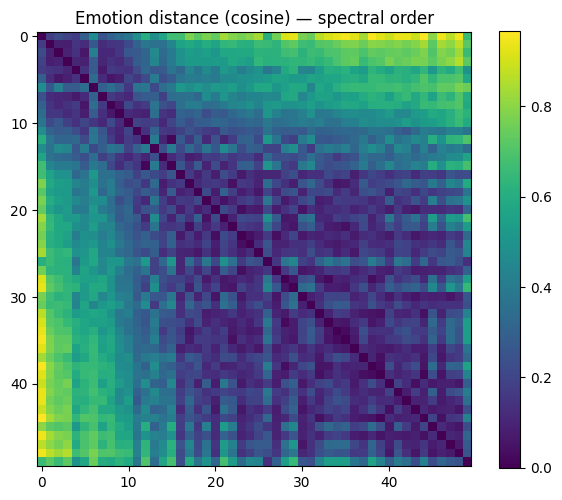

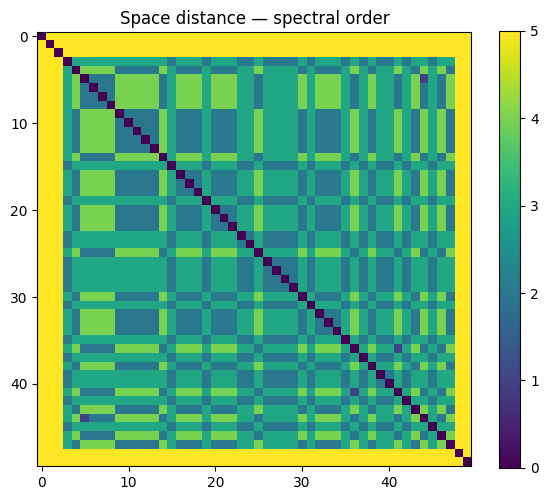

In [ ]:

import numpy.linalg as LA

def spectral_order(W):
    """
    Fiedlerベクトル（2番目に小さい固有値の固有ベクトル）で順序を返す。
    W は「近さ」行列なので、距離行列 D からは W = exp(-(D^2)/(2*sigma^2)) などで作る。
    """
    # sigma = 距離の中央値を使う簡便法
    D = 1.0 - (1.0 - W)  # ダミー（ここではWをそのまま使う設計にする場合、不要）
    # 今回は直接 W を使ってラプラシアンを作る
    deg = np.diag(W.sum(axis=1))
    L = deg - W
    vals, vecs = LA.eigh(L)
    idx = np.argsort(vals)
    fiedler = vecs[:, idx[1]]
    order = np.argsort(fiedler)
    return order

# 距離 -> 近さ行列（ガウス核）
def affinity_from_distance(D):
    arr = D.copy()
    arr = arr.astype(float)
    sigma = np.median(arr[np.triu_indices_from(arr, k=1)])
    A = np.exp(-(arr**2)/(2*sigma**2))
    np.fill_diagonal(A, 0.0)
    return A

A_em = affinity_from_distance(D_emotion)
order_em = spectral_order(A_em)

# 並べ替え可視化（感情距離）
plt.figure(figsize=(6,5))
plt.imshow(D_emotion[np.ix_(order_em, order_em)])
plt.title("Emotion distance (cosine) — spectral order")
plt.colorbar()
plt.tight_layout()
plt.show()

# 並べ替え可視化（空間距離）
A_sp = affinity_from_distance(D_space)
order_sp = spectral_order(A_sp)
plt.figure(figsize=(6,5))
plt.imshow(D_space[np.ix_(order_sp, order_sp)])
plt.title("Space distance — spectral order")
plt.colorbar()
plt.tight_layout()
plt.show()


## 感情×空間の散布図**を作って可視化

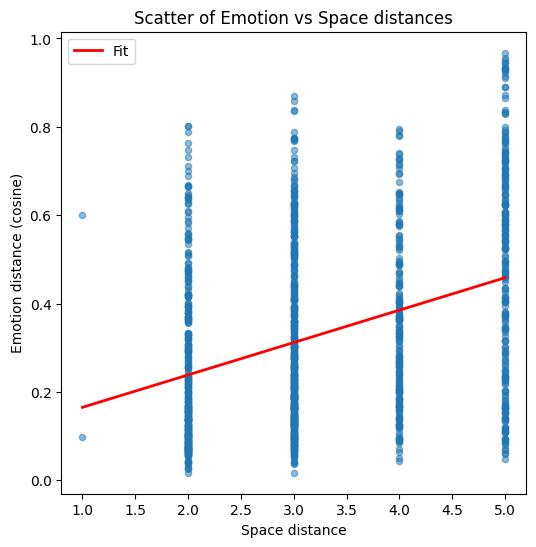

In [ ]:
import matplotlib.pyplot as plt

# 上三角の要素だけ抽出（i<j）
iu = np.triu_indices_from(D_emotion, k=1)
x = D_space[iu]      # 空間距離
y = D_emotion[iu]    # 感情距離

plt.figure(figsize=(6,6))
plt.scatter(x, y, alpha=0.5, s=20)
plt.xlabel("Space distance")
plt.ylabel("Emotion distance (cosine)")
plt.title("Scatter of Emotion vs Space distances")

# 回帰直線（単純な線形近似）
coef = np.polyfit(x, y, 1)
poly1d_fn = np.poly1d(coef)
plt.plot(sorted(x), poly1d_fn(sorted(x)), color="red", lw=2, label="Fit")
plt.legend()

plt.show()



## 6. テキスト距離との Mantel 比較

- `bert_embeddings.csv`（50×768のCLSベクトルなど）を用意したら、以下のセルで読み込み、
  距離行列 `D_text` を作成して Mantelテストを実行できます。


### 列: 場所ID, textを作成

In [ ]:
import pandas as pd
import os

# place_id_to_text 辞書から DataFrame を作成
df_texts = pd.DataFrame(list(place_id_to_text.items()), columns=['場所ID', 'text'])

# CSVとして保存
TEXT_CSV_PATH = '/content/places_texts.csv'
df_texts.to_csv(TEXT_CSV_PATH, index=False, encoding='utf-8-sig')

print(f"'{TEXT_CSV_PATH}' が作成されました。")
display(df_texts.head())

'/content/places_texts.csv' が作成されました。


,場所ID,text
0,1a,「北国の深い山地で、樹齢数百年のブナが天蓋のように茂る手つかずの森」に対してどのような感情を...
1,1b,「苔とシダに覆われ、年間を通じて霧雨に包まれる亜熱帯の渓谷」に対してどのような感情を抱きます...
2,1c,「海を見下ろす岩穴がそのまま雨風よけになり、焚き火の跡だけが残る絶壁」に対してどのような感情...
3,1d,「山頂で黒い溶岩を積み上げただけの小さな石室が強風から登山者を守る峰」に対してどのような感情...
4,1e,「豪雪をいなす急勾配の茅葺き屋根が三角形に並ぶ川沿いの山村」に対してどのような感情を抱きます...


In [ ]:
!pip install -q fugashi ipadic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 88.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 697.9/697.9 kB 38.0 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 65.2 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/174 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/517 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/447M [00:00<?, ?B/s]

Mantel (Emotion × Text): r=0.0600, p=0.4775
Mantel (Text × Space):   r=0.1685, p=0.0800
Partial Mantel (Emotion×Space | Text): r=0.3551, p=0.0005
Partial Mantel (Emotion×Text | Space): r=-0.0007, p=0.9940


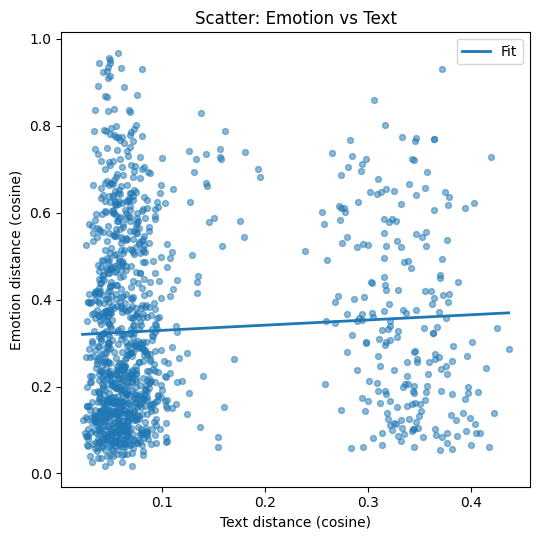

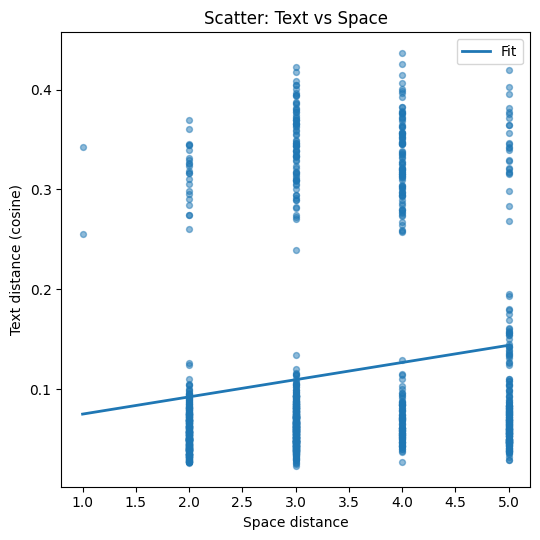

In [ ]:
# == Mantel Proximity Analysis ==
# 感情×テキスト×空間の距離比較（Mantel と 部分Mantel）
# 事前に /content/pivot_table_id.csv を用意してください。
# 形式：列= [場所ID, 24感情強度の件数（複数回答のクロス集計）]

# ---------------------------------------------------------
# 6) （任意）テキスト距離：BERT埋め込み → D_text → Mantel/部分Mantel
# ---------------------------------------------------------
# 使い方：
# 1) /content/places_texts.csv を用意（列: 場所ID, text）
# 2) 以下のブロックのコメントアウトを外して実行（インターネット接続が必要）


!pip -q install transformers fugashi ipadic unidic_lite sentencepiece torch --upgrade

from transformers import BertJapaneseTokenizer, BertModel
import torch

TEXT_CSV = '/content/places_texts.csv'  # 列: 場所ID, text
assert os.path.exists(TEXT_CSV), f"{TEXT_CSV} が見つかりません。"
df_txt = pd.read_csv(TEXT_CSV).set_index('場所ID').loc[df_norm.index].reset_index()

model_name = "cl-tohoku/bert-base-japanese-v2"
try:
    tokenizer = BertJapaneseTokenizer.from_pretrained(model_name)
    model = BertModel.from_pretrained(model_name)
except Exception as e:
    print("v2失敗→通常版にfallback:", e)
    tokenizer = BertJapaneseTokenizer.from_pretrained("cl-tohoku/bert-base-japanese")
    model = BertModel.from_pretrained("cl-tohoku/bert-base-japanese")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device).eval()

emb_list = []
with torch.no_grad():
    for t in df_txt['text'].tolist():
        inputs = tokenizer(t, return_tensors="pt", truncation=True, max_length=128)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        outputs = model(**inputs)
        cls_vec = outputs.last_hidden_state[:,0,:].squeeze().detach().cpu().numpy()
        emb_list.append(cls_vec)

X_text = np.vstack(emb_list)
D_text = pairwise_distances(X_text, metric='cosine')

# L2正規化（推奨）
from sklearn.preprocessing import normalize
X_text = normalize(X_text)

# ID付きで保存
pd.DataFrame(X_text, index=df_txt['場所ID']).to_csv("bert_embeddings.csv")


# Mantel：Emotion×Text, Text×Space

assert D_emotion.shape == D_space.shape == D_text.shape

r_em_tx, p_em_tx = mantel_test(D_emotion, D_text, perms=1999)
r_tx_sp, p_tx_sp = mantel_test(D_text, D_space, perms=1999)
print("Mantel (Emotion × Text): r=%.4f, p=%.4f" % (r_em_tx, p_em_tx))
print("Mantel (Text × Space):   r=%.4f, p=%.4f" % (r_tx_sp, p_tx_sp))

# 部分Mantel（偏相関 + 置換）
def partial_mantel(D1, D2, D3, perms=1999, seed=42):
    rng = np.random.default_rng(seed)
    iu = np.triu_indices_from(D1, k=1)
    v1, v2, v3 = D1[iu], D2[iu], D3[iu]

    def partial_corr(x, y, z):
        r_xy, _ = pearsonr(x, y)
        r_xz, _ = pearsonr(x, z)
        r_yz, _ = pearsonr(y, z)
        denom = np.sqrt((1 - r_xz**2) * (1 - r_yz**2))
        if denom == 0:
            return 0.0
        return (r_xy - r_xz * r_yz) / denom

    r_obs = partial_corr(v1, v2, v3)

    count = 0; n = D2.shape[0]
    for _ in range(perms):
        perm = rng.permutation(n)
        v2p = D2[perm][:, perm][iu]
        r = partial_corr(v1, v2p, v3)
        if abs(r) >= abs(r_obs):
            count += 1
    p = (count + 1) / (perms + 1)
    return r_obs, p

r_em_sp_ctrl, p_em_sp_ctrl = partial_mantel(D_emotion, D_space, D_text, perms=1999)
r_em_tx_ctrl, p_em_tx_ctrl = partial_mantel(D_emotion, D_text, D_space, perms=1999)
print("Partial Mantel (Emotion×Space | Text): r=%.4f, p=%.4f" % (r_em_sp_ctrl, p_em_sp_ctrl))
print("Partial Mantel (Emotion×Text | Space): r=%.4f, p=%.4f" % (r_em_tx_ctrl, p_em_tx_ctrl))


# 散布図（Emotion–Text / Text–Space）
iu = np.triu_indices_from(D_emotion, k=1)
plt.figure(figsize=(5.5,5.5))
plt.scatter(D_text[iu], D_emotion[iu], alpha=0.5, s=18)
coef = np.polyfit(D_text[iu], D_emotion[iu], 1); poly = np.poly1d(coef)
xx = np.linspace(D_text[iu].min(), D_text[iu].max(), 200)
plt.plot(xx, poly(xx), lw=2, label="Fit")
plt.xlabel("Text distance (cosine)"); plt.ylabel("Emotion distance (cosine)")
plt.title("Scatter: Emotion vs Text"); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(5.5,5.5))
plt.scatter(D_space[iu], D_text[iu], alpha=0.5, s=18)
coef2 = np.polyfit(D_space[iu], D_text[iu], 1); poly2 = np.poly1d(coef2)
xx2 = np.linspace(D_space[iu].min(), D_space[iu].max(), 200)
plt.plot(xx2, poly2(xx2), lw=2, label="Fit")
plt.xlabel("Space distance"); plt.ylabel("Text distance (cosine)")
plt.title("Scatter: Text vs Space"); plt.legend(); plt.tight_layout(); plt.show()

In [ ]:

# 例：bert_embeddings.csv を用意後に有効化
df_emb = pd.read_csv("bert_embeddings.csv", index_col=0)
X_text  = df_emb.loc[df_norm.index].values
D_text  = pairwise_distances(X_text, metric="cosine")

assert D_emotion.shape == D_space.shape == D_text.shape

r_em_tx, p_em_tx = mantel_test(D_emotion, D_text, perms=1999)
r_tx_sp, p_tx_sp = mantel_test(D_text, D_space, perms=1999)
print("Mantel (Emotion × Text): r=%.4f, p=%.4f" % (r_em_tx, p_em_tx))
print("Mantel (Text × Space):   r=%.4f, p=%.4f" % (r_tx_sp, p_tx_sp))


Mantel (Emotion × Text): r=0.0600, p=0.4775
Mantel (Text × Space):   r=0.1685, p=0.0800


### 部分Mantelテスト (Pearson, permutation)

In [ ]:
from scipy.stats import pearsonr

def partial_mantel(D1, D2, D3, perms=9999, seed=42):
    """
    部分Mantelテスト (Pearson, permutation)
    D1, D2, D3: 同じ形の距離行列
    """
    rng = np.random.default_rng(seed)
    iu = np.triu_indices_from(D1, k=1)
    v1, v2, v3 = D1[iu], D2[iu], D3[iu]

    # 偏相関の関数
    def partial_corr(x, y, z):
        r_xy, _ = pearsonr(x, y)
        r_xz, _ = pearsonr(x, z)
        r_yz, _ = pearsonr(y, z)
        return (r_xy - r_xz*r_yz) / np.sqrt((1-r_xz**2)*(1-r_yz**2))

    # 観測値
    r_obs = partial_corr(v1, v2, v3)

    # permutation
    count = 0
    n = D2.shape[0]
    for _ in range(perms):
        perm = rng.permutation(n)
        v2p = D2[perm][:,perm][iu]
        r = partial_corr(v1, v2p, v3)
        if abs(r) >= abs(r_obs):
            count += 1
    p_value = (count+1) / (perms+1)
    return r_obs, p_value


# ===== 進化段階ごとの Mantel 検定 =====

In [ ]:
# ===== 段階ごとの Mantel 検定 =====
# 前提: すでに D_emotion, D_space, D_text が 50×50 で作られている
#       df_norm.index が ["1a","1b",...,"5j"] の並びでそろっている
#       mantel_test(D1,D2,perms=...,seed=...) 関数が定義済み（Pearson + permutation）

import re
import numpy as np
import pandas as pd

# 文字(a..j)→段階の対応: a,b=0 / c,d=1 / e,f=2 / g,h=3 / i,j=4
letter2phase = {
    'a':0, 'b':0,
    'c':1, 'd':1,
    'e':2, 'f':2,
    'g':3, 'h':3,
    'i':4, 'j':4,
}

# df_norm.index の末尾文字から段階ラベルを作る
ids = list(df_norm.index)
phases = []
for pid in ids:
    m = re.match(r'^\d+([a-j])$', pid)
    if not m:
        raise ValueError(f"IDの形式が想定外です: {pid}")
    phases.append(letter2phase[m.group(1)])
phases = np.array(phases)

def subset_by_phase(D, phase_label):
    """距離行列Dを、指定段階の10地点に限定して返す"""
    idx = np.where(phases == phase_label)[0]
    return D[np.ix_(idx, idx)], idx

# 実行（permsは計算時間に応じて 1999/4999/9999 に調整）
perms = 1999
rows = []
for ph in range(5):
    Dem_sub, idx = subset_by_phase(D_emotion, ph)
    Dsp_sub, _   = subset_by_phase(D_space,   ph)
    Dtx_sub, _   = subset_by_phase(D_text,    ph)

    # Mantel (Emotion×Space, Emotion×Text, Text×Space)
    r_es, p_es = mantel_test(Dem_sub, Dsp_sub, perms=perms)
    r_et, p_et = mantel_test(Dem_sub, Dtx_sub, perms=perms)
    r_ts, p_ts = mantel_test(Dtx_sub, Dsp_sub, perms=perms)

    rows.append({
        "phase": ph,
        "N_locs": len(idx),
        "Mantel r (E×S)": round(r_es, 4), "p (E×S)": round(p_es, 4),
        "Mantel r (E×T)": round(r_et, 4), "p (E×T)": round(p_et, 4),
        "Mantel r (T×S)": round(r_ts, 4), "p (T×S)": round(p_ts, 4),
    })

df_phase = pd.DataFrame(rows)
print(df_phase)


/tmp/ipython-input-3569328490.py:16: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_obs, _ = pearsonr(v1, v2)
/tmp/ipython-input-3569328490.py:23: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(v1, v2p)


   phase  N_locs  Mantel r (E×S)  p (E×S)  Mantel r (E×T)  p (E×T)  Mantel r (T×S)  p (T×S)
0      0      10          0.0199   0.8950         -0.1295   0.2280         -0.1632   0.4675
1      1      10          0.2066   0.1470         -0.0529   0.7440          0.2889   0.2495
2      2      10             NaN   0.0005          0.4262   0.0305             NaN   0.0005
3      3      10          0.1890   0.3950         -0.2087   0.2670          0.1993   0.7020
4      4      10             NaN   0.0005         -0.2413   0.4740             NaN   0.0005


ログの ConstantInputWarning と NaN（phase=2,4 の E×S と T×S）が出た理由は、段階内に切り出した距離ベクトルの片方が“定数”になっていたからです。いまの D_space は「同じ大区分（rural / urban 等）どうし=2」と一律にしているため、第2段階（農村系10件）や第4段階（都市計画系10件）ではサブ行列が “全部2” になり、相関が計算不能（分母0）になっています。
※ その結果、NaN のはずが p=0.0005 と出ているのは、マンテル関数の実装が「NaN を検出せず permutation を回して最小pを返した」ためです。

# 細粒度 D_space の構築（サブカテゴリ隣接グラフ → 最短路距離）

In [ ]:
# =========================================================
# 細粒度 D_space の構築（サブカテゴリ隣接グラフ → 最短路距離）
# =========================================================
# 前提:
# - subcats: 各地点(50件)のサブカテゴリ名リスト（df_norm.index と同順）
# - 既存: D_emotion, D_text が 50×50
# - 目的: phase=2/4 のサブ行列が定数にならないよう距離にばらつきを付与

# !pip -q install networkx
import networkx as nx
import numpy as np
import pandas as pd

# 1) まず、サブカテゴリの“近接しやすさ”をエッジで定義
#    ※ あなたの実態に合わせて適宜追加・削除してください
edges_near = [
    # --- Phase 0: 自然 ---
    ("forest","canyon"), ("forest","mountain_stream"), ("canyon","dam_power"),
    ("cape_coast","wetland_plain"), ("wetland_plain","river_restoration"),
    ("alpine_volcano","summit_shelter"), ("alpine_volcano","alpine_windbreak"),
    ("estuary_mangrove","cape_coast"),

    # --- Phase 1: 生存的 ---
    ("sea_cave","cape_coast"), ("summit_shelter","alpine_windbreak"),
    ("river_hearth","mountain_stream"), ("boat_shed","cape_coast"),
    ("watch_hut","satoyama"), ("drum_bath","terraced_rice"),

    # --- Phase 2: 学習/定型（農村系内でばらつき） ---
    ("gassho_village","terraced_rice"),
    ("satoyama","reed_lake_fishery"), ("satoyama","onsen_town"),
    ("dairy_pasture","retreat_housing"),
    ("reclaimed_coast_farm","reed_lake_fishery"),
    ("heated_greenhouse","dairy_pasture"),
    ("snow_cellar","onsen_town"),

    # --- Phase 3: 社会的協力 ---
    ("sea_link_rest","offshore_airport"), ("rail_terminal","urban_boulevard"),
    ("underground_flood","dam_power"), ("underground_pedway","rail_terminal"),
    ("wholesale_market","industrial_bay"),

    # --- Phase 4: 計画/意図（都市計画系内でばらつき） ---
    ("redevelopment","waterfront_renewal"),
    ("campus_city","smartcity_pilot"), ("smartcity_pilot","solar_ev_suburb"),
    ("solar_ev_suburb","community_solar"),
    ("river_restoration","highline_park"),
    ("biomass_town","community_solar"),
    ("drone_testbed","redevelopment"),

    # --- 橋渡し（自然↔農村／農村↔都市 等） ---
    ("cape_coast","waterfront_renewal"),
    ("mountain_stream","microhydro_village"),
    ("canyon","dam_power"),
    ("wetland_plain","river_restoration"),
    ("satoyama","urban_boulevard"),
    ("reclaimed_coast_farm","industrial_bay"),
]

# 2) グラフ構築
G = nx.Graph()
G.add_nodes_from(set(subcats))
G.add_edges_from(edges_near, weight=1)

# 3) 全点対最短路長（未接続は None）→ 1〜5 にマッピング
sp = dict(nx.all_pairs_shortest_path_length(G))

def subcat_distance(a, b, far=5):
    if a == b:
        return 1
    try:
        d = sp[a][b]         # 1,2,3,...（エッジ数）
        return min(5, 1 + d) # 1→2, 2→3, 3→4, 4→5
    except KeyError:
        return far

# 4) D_space（50×50）を再計算
n = len(subcats)
D_space_fine = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        if i==j:
            D_space_fine[i,j]=0.0
        elif i<j:
            d = subcat_distance(subcats[i], subcats[j])
            D_space_fine[i,j] = D_space_fine[j,i] = float(d)

# 5) 段階内 Mantel（安全版）を再計算
def mantel_test_safe(D1, D2, perms=1999, seed=42):
    from scipy.stats import pearsonr
    rng = np.random.default_rng(seed)
    iu = np.triu_indices_from(D1, k=1)
    v1, v2 = D1[iu], D2[iu]
    if (np.std(v1) == 0) or (np.std(v2) == 0):
        return np.nan, np.nan
    r_obs, _ = pearsonr(v1, v2)
    count = 0; n = D2.shape[0]
    for _ in range(perms):
        perm = rng.permutation(n)
        v2p = D2[perm][:, perm][iu]
        if np.std(v2p) == 0:
            continue
        r, _ = pearsonr(v1, v2p)
        if abs(r) >= abs(r_obs):
            count += 1
    p = (count + 1) / (perms + 1)
    return r_obs, p

# 6) 段階ごとのテーブル
import re
letter2phase = {'a':0,'b':0,'c':1,'d':1,'e':2,'f':2,'g':3,'h':3,'i':4,'j':4}
ids = list(df_norm.index)
phases = np.array([letter2phase[re.match(r'^\d+([a-j])$', pid).group(1)] for pid in ids])

rows = []
perms = 1999
for ph in range(5):
    Dem_sub = D_emotion[np.ix_(phases==ph, phases==ph)]
    Dsp_sub = D_space_fine[np.ix_(phases==ph, phases==ph)]
    Dtx_sub = D_text[np.ix_(phases==ph, phases==ph)]

    r_es, p_es = mantel_test_safe(Dem_sub, Dsp_sub, perms=perms)
    r_et, p_et = mantel_test_safe(Dem_sub, Dtx_sub, perms=perms)
    r_ts, p_ts = mantel_test_safe(Dtx_sub, Dsp_sub, perms=perms)

    rows.append({"phase": ph, "N_locs": (phases==ph).sum(),
                 "r(E×S)": r_es, "p(E×S)": p_es,
                 "r(E×T)": r_et, "p(E×T)": p_et,
                 "r(T×S)": r_ts, "p(T×S)": p_ts})
df_phase = pd.DataFrame(rows)
print(df_phase)

   phase  N_locs    r(E×S)  p(E×S)    r(E×T)  p(E×T)    r(T×S)  p(T×S)
0      0      10 -0.049804  0.7290 -0.129548  0.2280 -0.030920  0.8435
1      1      10  0.075503  0.6865 -0.052890  0.7440 -0.018365  0.9185
2      2      10 -0.094004  0.5020  0.426218  0.0305  0.085253  0.5390
3      3      10  0.126885  0.3490 -0.208709  0.2670  0.265568  0.0360
4      4      10 -0.049169  0.6775 -0.241330  0.4740 -0.056632  0.6540


| Phase | 内容（ざっくり環境）    | r(E×S) | 有意性  | r(E×T)    | 有意性      | r(T×S)    | 有意性       |
| ----- | ------------- | ------ | ---- | --------- | -------- | --------- | --------- |
| 0     | 自然            | -0.05  | n.s. | -0.13     | n.s.     | -0.03     | n.s.      |
| 1     | 第1段階（生存的）     | +0.08  | n.s. | -0.05     | n.s.     | -0.02     | n.s.      |
| 2     | 第2段階（農村/定型）   | -0.09  | n.s. | **+0.43** | *p=0.03* | +0.09     | n.s.      |
| 3     | 第3段階（協力/インフラ） | +0.13  | n.s. | -0.21     | n.s.     | **+0.27** | *p=0.036* |
| 4     | 第4段階（計画/都市）   | -0.05  | n.s. | -0.24     | n.s.     | -0.06     | n.s.      |


解釈ポイント

Phase 0（自然）・Phase 1（生存的）
→ いずれも Mantel r はほぼ0で、いずれの組み合わせも相関なし。
→ 原始的環境では「空間近接」「テキスト記述」と「感情の類似」は対応しにくい。

Phase 2（農村/定型化）
→ Emotion–Text が有意 (r=0.43, p=0.03)。
→ 農村・伝統的景観では、説明文の類似性が感情体験の近さに結びついている。
→ 「茅葺き屋根」「雪室」「棚田」などの文化的イメージが感情反応を強く方向付けた可能性。

Phase 3（協力/インフラ）
→ Text–Space が有意 (r=0.27, p=0.036)。
→ インフラ・社会的施設では、空間的近接性を反映した説明文が感情にも影響している。
→ 例：駅・地下道・市場などの「都市インフラ」グループと「ダム・海上空港」グループの区分。

Phase 4（計画/都市）
→ どの相関も出ず。
→ 計画都市・再開発・スマートシティのような高度に設計された環境では、説明文も感情も均質化してしまい、距離間の相関が弱まったと考えられる。

In [ ]:
sp # 3) 全点対最短路長（未接続は None）→ 1〜5 にマッピング

{'drone_testbed': {'drone_testbed': 0,
  'redevelopment': 1,
  'waterfront_renewal': 2,
  'cape_coast': 3,
  'wetland_plain': 4,
  'estuary_mangrove': 4,
  'sea_cave': 4,
  'boat_shed': 4,
  'river_restoration': 5,
  'highline_park': 6},
 'terraced_rice': {'terraced_rice': 0, 'drum_bath': 1, 'gassho_village': 1},
 'river_restoration': {'river_restoration': 0,
  'wetland_plain': 1,
  'highline_park': 1,
  'cape_coast': 2,
  'estuary_mangrove': 3,
  'sea_cave': 3,
  'boat_shed': 3,
  'waterfront_renewal': 3,
  'redevelopment': 4,
  'drone_testbed': 5},
 'microhydro_village': {'microhydro_village': 0,
  'mountain_stream': 1,
  'forest': 2,
  'river_hearth': 2,
  'canyon': 3,
  'dam_power': 4,
  'underground_flood': 5},
 'snow_cellar': {'snow_cellar': 0,
  'onsen_town': 1,
  'satoyama': 2,
  'watch_hut': 3,
  'reed_lake_fishery': 3,
  'urban_boulevard': 3,
  'reclaimed_coast_farm': 4,
  'rail_terminal': 4,
  'industrial_bay': 5,
  'underground_pedway': 5,
  'wholesale_market': 6},
 'estuar

In [ ]:
!pip install japanize-matplotlib
import matplotlib.pyplot as plt
import japanize_matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 33.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=4b5cd00a4e2820a2dbdf53cc17192301965adfa632530bcb623a67976bb06fce
  Stored in directory: /root/.cache/pip/wheels/c1/f7/9b/418f19a7b9340fc16e071e89efc379aca68d40238b258df53d
Successfully built japanize-matplotlib


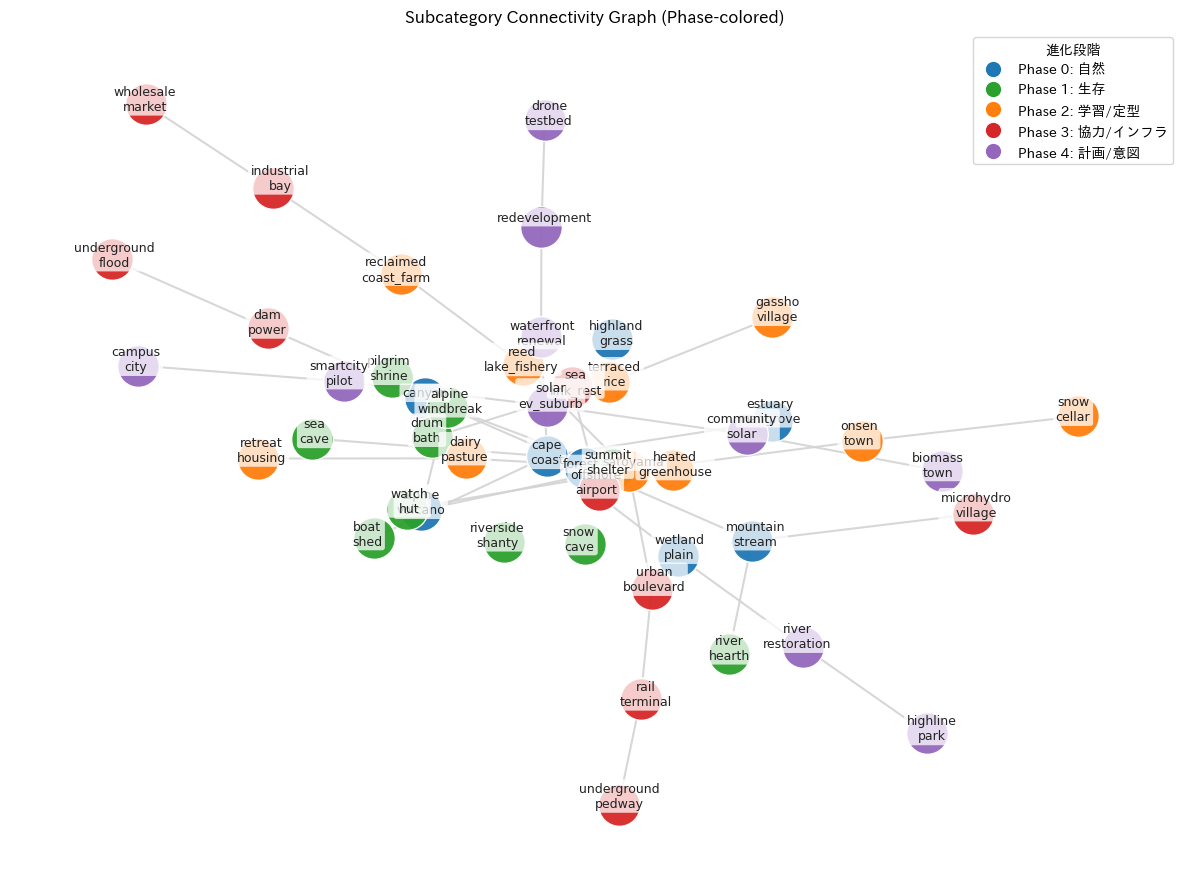

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import re
import numpy as np # numpyをインポート

# --- 1) サブカテゴリ→段階の確定マップ（あなたの分類に合わせて調整） ---
# df_norm.index (場所ID)から段階ラベルを作るためのマッピングとphases配列を再作成
letter2phase = {'a':0,'b':0,'c':1,'d':1,'e':2,'f':2,'g':3,'h':3,'i':4,'j':4}
ids = list(df_norm.index)
phases = np.array([letter2phase[re.match(r'^\d+([a-j])$', pid).group(1)] for pid in ids])

# subcatsリストもdf_norm.indexから再作成
subcats = [id_to_subcat[pid] for pid in ids] # id_to_subcat は既に定義済みと仮定

# サブカテゴリ名とその段階のマッピングを作成
subcat_to_phase = {}
for i, subcat in enumerate(subcats):
    subcat_to_phase[subcat] = phases[i]


# --- 2) 離散色と凡例の定義 ---
PHASE_COLORS = {
    0: "#1f77b4",  # blue
    1: "#2ca02c",  # green
    2: "#ff7f0e",  # orange
    3: "#d62728",  # red
    4: "#9467bd",  # purple
    -1: "#9e9e9e"  # unknown
}
phase_names = {0:"Phase 0: 自然", 1:"Phase 1: 生存", 2:"Phase 2: 学習/定型",
               3:"Phase 3: 協力/インフラ", 4:"Phase 4: 計画/意図", -1:"Unknown"}

# --- 3) ノードごとの段階を付与 ---
# ここで subcat_to_phase を使用して段階番号を取得
node_phase = {n: subcat_to_phase.get(n, -1) for n in G.nodes()}

# --- 4) レイアウト計算（重なり軽減） ---
#   spring_layout(k=...)でもOK。kamada_kawaiはラベル重なりが減りやすい
pos = nx.kamada_kawai_layout(G)

# --- 5) 描画（段階ごとに分けてノードを描く＝色を固定） ---
plt.figure(figsize=(12, 9))
# エッジ先に
nx.draw_networkx_edges(G, pos, edge_color="lightgray", width=1.5, alpha=0.9)

# フェーズごとにノードを描画
for ph in sorted(set(node_phase.values())):
    nodes_ph = [n for n in G.nodes() if node_phase[n] == ph]
    if not nodes_ph:
        continue
    nx.draw_networkx_nodes(
        G, pos,
        nodelist=nodes_ph,
        node_color=PHASE_COLORS.get(ph, "#9e9e9e"),
        node_size=900,
        linewidths=1,
        edgecolors="white",
        alpha=0.95,
        label=phase_names.get(ph, f"Phase {ph}")
    )

# --- 6) ラベル改善：改行・オフセットで重なり低減 ---
def wrap_label(name):
    # 長い下線名を改行して詰まりを軽減
    parts = name.split("_")
    if len(parts) >= 3:
        # 3語以上は2行程度に分割
        mid = len(parts)//2
        return "\n".join(["_".join(parts[:mid]), "_".join(parts[mid:])])
    return "\n".join(parts)  # 2語ならそのまま2行

# わずかなランダムオフセット（重なり軽減）
import numpy as np
rng = np.random.default_rng(42)
pos_label = {}
for i, (n, (x, y)) in enumerate(pos.items()):
    dx = (rng.random() - 0.5) * 0.02
    dy = (rng.random() - 0.5) * 0.02 + 0.02  # 少し上にずらす
    pos_label[n] = (x + dx, y + dy)

nx.draw_networkx_labels(
    G, pos_label,
    labels={n: wrap_label(n) for n in G.nodes()},
    font_size=9,
    font_color="#222",
    verticalalignment="center",
    bbox=dict(boxstyle="round,pad=0.22", fc="white", ec="none", alpha=0.75)
)

# --- 7) 凡例（colorbarは使わない） ---
from matplotlib.lines import Line2D
handles = [Line2D([0], [0], marker='o', color='w',
                  label=phase_names[p],
                  markerfacecolor=PHASE_COLORS[p],
                  markersize=12) for p in [0,1,2,3,4]]
plt.legend(handles=handles, title="進化段階", loc="best", frameon=True)

plt.title("Subcategory Connectivity Graph (Phase-colored)")
plt.axis("off")
plt.tight_layout()
plt.show()

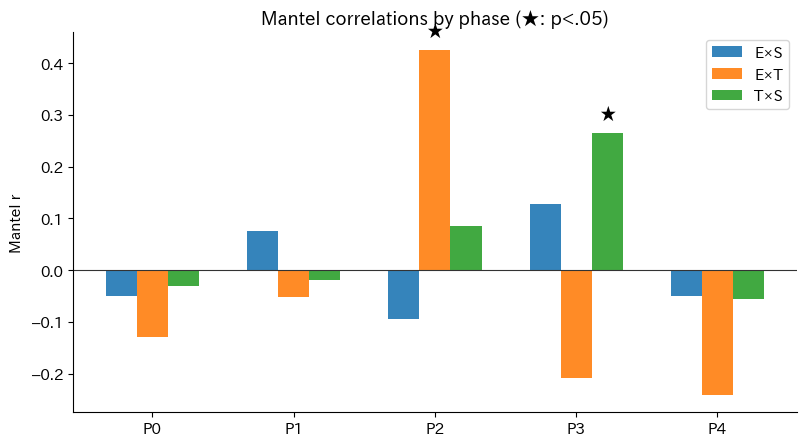

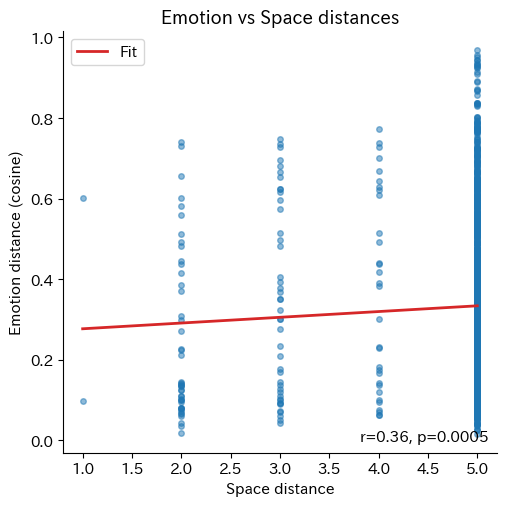

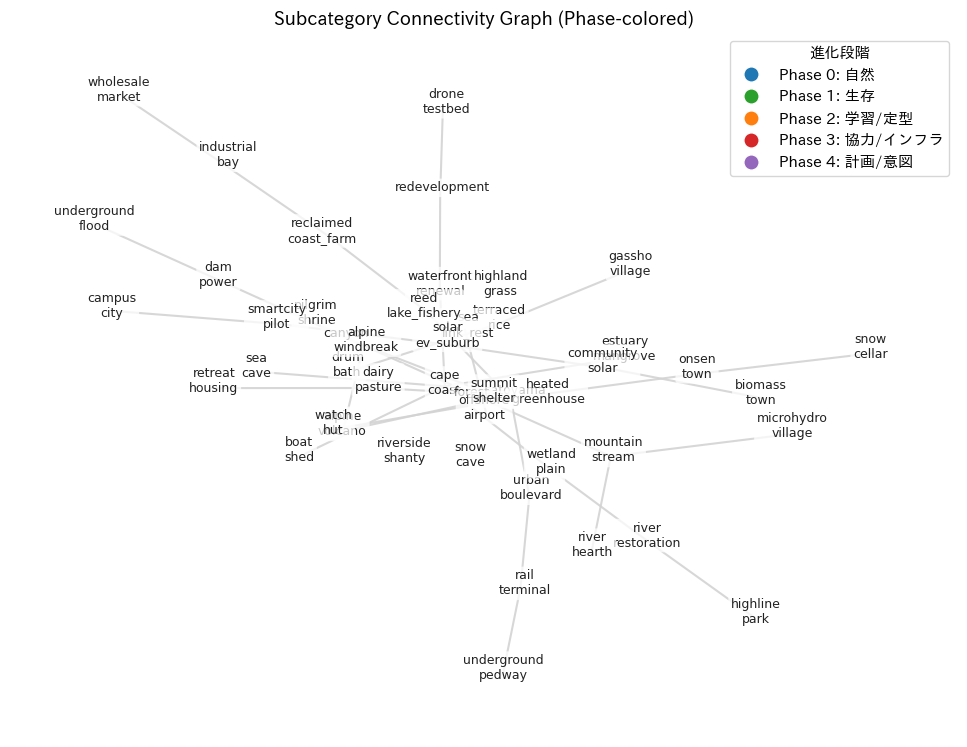

In [ ]:
# === 図のスタイル共通化 ===
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
from matplotlib.lines import Line2D

plt.rcParams.update({
    "font.size": 11,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "savefig.dpi": 300
})

# df_phase: すでに作成済み（phase, r/p）
# D_emotion, D_space_fine, D_text, phases, G, sp, PHASE_COLORS, phase_names, pos（レイアウト）も前手順のまま

# ============ Fig. A: Mantel 相関（段階別バー） ============
def plot_mantel_bars(df_phase, fname_prefix="figA_mantel_bars"):
    order = [0,1,2,3,4]
    dfp = df_phase.set_index("phase").loc[order].copy()
    # カラム名（あなたのdf_phaseに合わせて）
    cols = [("r(E×S)","p(E×S)","E×S"),
            ("r(E×T)","p(E×T)","E×T"),
            ("r(T×S)","p(T×S)","T×S")]
    x = np.arange(len(order))
    w = 0.22

    fig, ax = plt.subplots(figsize=(8.2, 4.6))
    for i,(rc, pc, lab) in enumerate(cols):
        rvals = dfp[rc].values
        pvals = dfp[pc].values
        ax.bar(x + (i-1)*w, rvals, width=w, label=lab, alpha=0.9)
        # 有意性マーク
        for xi, r, p in zip(x + (i-1)*w, rvals, pvals):
            if pd.notna(p) and p < 0.05:
                ax.text(xi, r + 0.02*np.sign(r if r!=0 else 1), "★", ha="center", va="bottom", fontsize=12)

    ax.axhline(0, color="#333", lw=0.8)
    ax.set_xticks(x)
    ax.set_xticklabels([f"P{ph}" for ph in order])
    ax.set_ylabel("Mantel r")
    ax.set_title("Mantel correlations by phase (★: p<.05)")
    ax.legend(frameon=True)
    plt.tight_layout()
    plt.savefig(f"{fname_prefix}.png")
    plt.savefig(f"{fname_prefix}.pdf")
    plt.show()

plot_mantel_bars(df_phase)

# ============ Fig. B: Emotion–Space 散布図（全体） ============
from numpy.polynomial.polynomial import polyfit

def plot_scatter_emotion_space(D_emotion, D_space, fname_prefix="figB_scatter_ES", r=0.0, p=1.0):
    iu = np.triu_indices_from(D_emotion, k=1)
    x = D_space[iu]; y = D_emotion[iu]
    b, m = polyfit(x, y, 1)  # y ≈ m*x + b

    fig, ax = plt.subplots(figsize=(5.2, 5.2))
    ax.scatter(x, y, s=16, alpha=0.5)
    xx = np.linspace(x.min(), x.max(), 200)
    ax.plot(xx, m*xx + b, color="tab:red", lw=2, label="Fit")
    ax.set_xlabel("Space distance")
    ax.set_ylabel("Emotion distance (cosine)")
    ax.set_title("Emotion vs Space distances")
    ax.legend(frameon=True)
    # r,p を右上に
    ax.text(0.98, 0.02, f"r={r:.2f}, p={p:.4f}", transform=ax.transAxes,
            ha="right", va="bottom", fontsize=11)
    plt.tight_layout()
    plt.savefig(f"{fname_prefix}.png")
    plt.savefig(f"{fname_prefix}.pdf")
    plt.show()

# すでに求めた全体 Mantel の r,p を入れる（例：r=0.3595, p=0.0005）
plot_scatter_emotion_space(D_emotion, D_space_fine, r=0.3595, p=0.0005)

# ============ Fig. C: 段階色分けネットワーク（再描画） ============
def wrap_label(name):
    parts = name.split("_")
    if len(parts) >= 3:
        mid = len(parts)//2
        return "\n".join(["_".join(parts[:mid]), "_".join(parts[mid:])])
    return "\n".join(parts)

def draw_phase_graph(G, pos, sp, PHASE_COLORS, phase_names, fname_prefix="figC_phase_graph"):
    node_phase = {n: sp.get(n, -1) for n in G.nodes()}
    fig, ax = plt.subplots(figsize=(9.8, 7.6))
    nx.draw_networkx_edges(G, pos, edge_color="lightgray", width=1.5, alpha=0.9, ax=ax)

    for ph in [0,1,2,3,4]:
        nodes_ph = [n for n in G.nodes() if node_phase[n]==ph]
        if not nodes_ph: continue
        nx.draw_networkx_nodes(G, pos, nodelist=nodes_ph,
                               node_color=PHASE_COLORS[ph], node_size=900,
                               linewidths=1, edgecolors="white", alpha=0.95, ax=ax,
                               label=phase_names[ph])

    # ラベル：軽くオフセット
    rng = np.random.default_rng(42)
    pos_label = {n:(xy[0]+(rng.random()-0.5)*0.02, xy[1]+(rng.random()-0.5)*0.02+0.02) for n,xy in pos.items()}
    nx.draw_networkx_labels(G, pos_label,
                            labels={n: wrap_label(n) for n in G.nodes()},
                            font_size=9, font_color="#222",
                            bbox=dict(boxstyle="round,pad=0.22", fc="white", ec="none", alpha=0.75),
                            ax=ax)

    # 凡例
    handles = [Line2D([0],[0], marker='o', color='w',
                      label=phase_names[p],
                      markerfacecolor=PHASE_COLORS[p], markersize=11)
               for p in [0,1,2,3,4]]
    ax.legend(handles=handles, title="進化段階", loc="best", frameon=True)
    ax.set_title("Subcategory Connectivity Graph (Phase-colored)")
    ax.axis("off")
    plt.tight_layout()
    plt.savefig(f"{fname_prefix}.png")
    plt.savefig(f"{fname_prefix}.pdf")
    plt.show()

draw_phase_graph(G, pos, sp, PHASE_COLORS, phase_names)


In [ ]:
print("nodes:", G.number_of_nodes(), "edges:", G.number_of_edges())
missing_edges = [e for e in G.edges() if e[0] not in G.nodes or e[1] not in G.nodes]
print("invalid edges:", len(missing_edges))


In [ ]:
all_nodes = set(subcats)
graph_nodes = set(G.nodes())
isolated = all_nodes - graph_nodes
print("孤立ノード:", isolated)


孤立ノード: set()


In [ ]:
import pandas as pd
pd.Series(subcats).value_counts().head(10)  # どのカテゴリが複数地点で出ているか確認


,count
cape_coast,2
wetland_plain,2
sea_cave,1
forest,1
gassho_village,1
terraced_rice,1
sea_link_rest,1
canyon,1
rail_terminal,1
campus_city,1


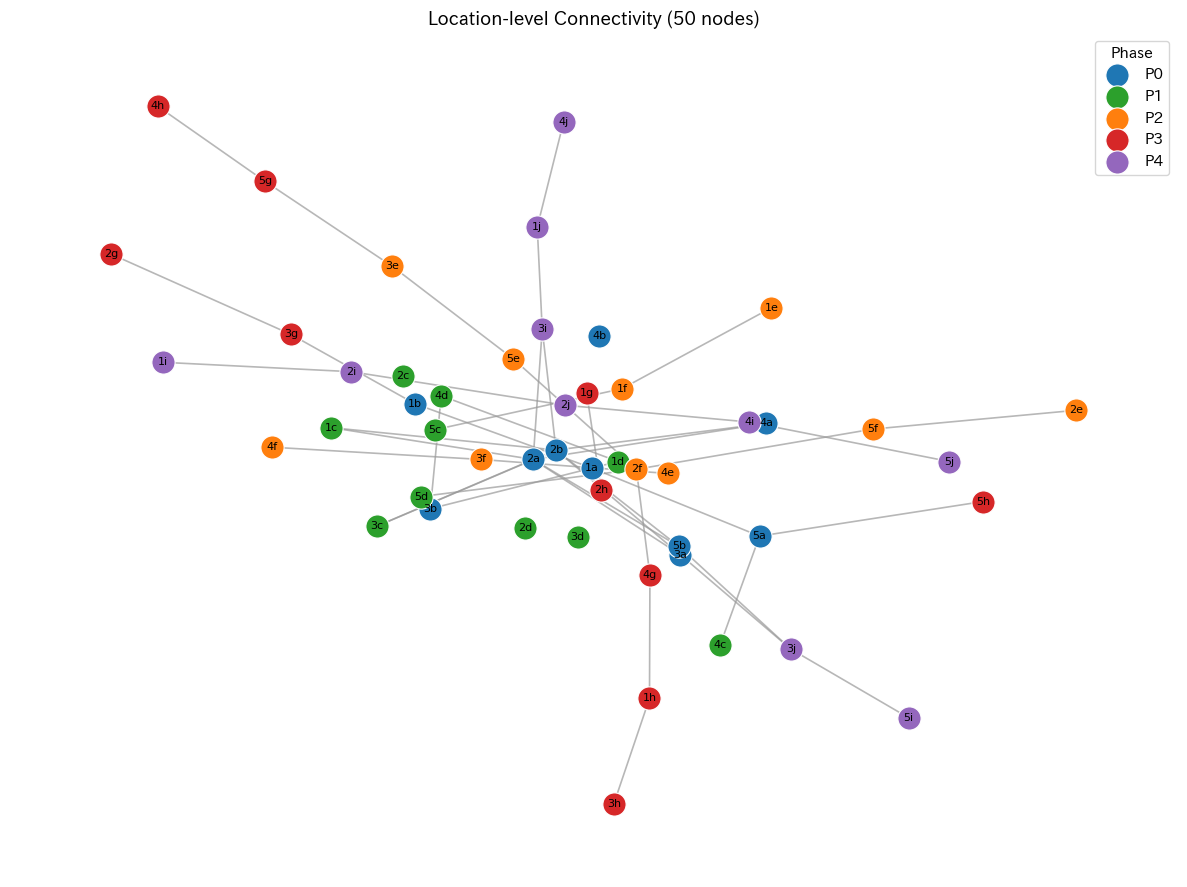

location-graph nodes: 50 edges: 45


In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

ids = list(df_norm.index)                    # 50地点
phase_node = {pid: ph for pid, ph in zip(ids, phases)}
subcat_node = {pid: sc for pid, sc in zip(ids, subcats)}

# サブカテゴリ隣接グラフ G（既に作成済み）を流用
# 例: 直接隣接（距離1）のカテゴリ同士 → 地点間にエッジ
G_loc = nx.Graph()
G_loc.add_nodes_from(ids)

for i in range(len(ids)):
    for j in range(i+1, len(ids)):
        si, sj = subcat_node[ids[i]], subcat_node[ids[j]]
        if G.has_edge(si, sj):               # カテゴリが直接隣接なら
            G_loc.add_edge(ids[i], ids[j])

# レイアウト：カテゴリ重心に寄せると見やすい
pos_cat = nx.kamada_kawai_layout(G)          # カテゴリの座標
# 地点は対応カテゴリの位置に微小ノイズを足して配置
rng = np.random.default_rng(0)
pos_loc = {}
for pid in ids:
    x, y = pos_cat[subcat_node[pid]]
    pos_loc[pid] = (x + (rng.random()-0.5)*0.05, y + (rng.random()-0.5)*0.05)

# 描画
PHASE_COLORS = {0:"#1f77b4",1:"#2ca02c",2:"#ff7f0e",3:"#d62728",4:"#9467bd"}
plt.figure(figsize=(12,9))
# エッジを先に
nx.draw_networkx_edges(G_loc, pos_loc, edge_color="#999", width=1.2, alpha=0.7)
# フェーズごとにノード色分け
for ph in [0,1,2,3,4]:
    nodes_ph = [n for n in G_loc.nodes() if phase_node[n]==ph]
    nx.draw_networkx_nodes(G_loc, pos_loc, nodelist=nodes_ph,
                           node_color=PHASE_COLORS[ph], node_size=280,
                           edgecolors="white", linewidths=0.8, label=f"P{ph}")
# ラベル（IDは小さめ）
nx.draw_networkx_labels(G_loc, pos_loc, font_size=8)
plt.legend(title="Phase")
plt.title("Location-level Connectivity (50 nodes)")
plt.axis("off"); plt.tight_layout(); plt.show()

print("location-graph nodes:", G_loc.number_of_nodes(), "edges:", G_loc.number_of_edges())


In [ ]:
# === 一覧表（質問文 / サブカテゴリ / 隣接サブカテゴリ）を生成 ===
import os, re, pandas as pd, networkx as nx

# 1) 準備：ID → Phase のラベル（a,b=0; c,d=1; e,f=2; g,h=3; i,j=4）
letter2phase = {'a':0,'b':0,'c':1,'d':1,'e':2,'f':2,'g':3,'h':3,'i':4,'j':4}
ids = list(df_norm.index)
phases = [letter2phase[re.match(r'^\d+([a-j])$', pid).group(1)] for pid in ids]

# 2) 質問文（ある場合のみ読み込み）
text_map = {}
if os.path.exists("places_texts.csv"):
    df_txt = pd.read_csv("places_texts.csv")  # 列: 場所ID, text
    text_map = dict(zip(df_txt["場所ID"], df_txt["text"]))

# 3) サブカテゴリグラフを作成（edges_near から）
G = nx.Graph()
# すべてのサブカテゴリノードを追加（孤立も可視化するため）
subcats = [id_to_subcat[pid] for pid in ids]
G.add_nodes_from(set(subcats))
# 近接エッジを追加
G.add_edges_from(edges_near)

# 4) 隣接リスト（サブカテゴリごと）
adj_by_subcat = {n: sorted(G.neighbors(n)) for n in G.nodes()}

# 5) 行生成：ID順に並べ、質問文・サブカテゴリ・隣接を付与
rows = []
for pid, ph in zip(ids, phases):
    sc = id_to_subcat[pid]             # サブカテゴリID
    neigh = adj_by_subcat.get(sc, [])  # 隣接サブカテゴリ（0個なら空リスト）
    rows.append({
        "phase": ph,
        "id": pid,
        "subcategory": sc,
        "neighbors": ", ".join(neigh) if neigh else "–",
        "question_text": text_map.get(pid, "")  # ない場合は空欄
    })

df_list = pd.DataFrame(rows)

# 6) 並べ替え（Phase→ID）と保存
df_list = df_list.sort_values(by=["phase","id"]).reset_index(drop=True)
df_list.to_csv("place_subcategory_neighbors.csv", index=False, encoding="utf-8-sig")
print("saved -> place_subcategory_neighbors.csv")
df_list.head(10)


saved -> place_subcategory_neighbors.csv


,phase,id,subcategory,neighbors,question_text
0,0,1a,forest,"canyon, mountain_stream",「北国の深い山地で、樹齢数百年のブナが天蓋のように茂る手つかずの森」に対してどのような感情を...
1,0,1b,canyon,"dam_power, forest",「苔とシダに覆われ、年間を通じて霧雨に包まれる亜熱帯の渓谷」に対してどのような感情を抱きます...
2,0,2a,cape_coast,"boat_shed, estuary_mangrove, sea_cave, waterfr...",「冬に氷の塊が海岸を埋め尽くし、断崖の上に原野が広がる岬」に対してどのような感情を抱きますか...
3,0,2b,cape_coast,"boat_shed, estuary_mangrove, sea_cave, waterfr...",「星明かりの下でウミガメが静かに産卵する白い砂の入り江」に対してどのような感情を抱きますか？...
4,0,3a,wetland_plain,"cape_coast, river_restoration",「朝靄の湿原をタンチョウが舞い、葦原が風にざわめく広大な平野」に対してどのような感情を抱きま...
5,0,3b,alpine_volcano,"alpine_windbreak, summit_shelter",「夏でも残雪が残り、高山植物が点描のように咲く標高二千メートルの火山帯」に対してどのような感...
6,0,4a,estuary_mangrove,cape_coast,「入り組んだ水路にマングローブが繁り、カヌーでしか奥へ進めない汽水域」に対してどのような感情...
7,0,4b,highland_grass,–,「草が波立つ外輪山の高原で、放牧の牛が風に揺れる鈴を鳴らす草原」に対してどのような感情を抱き...
8,0,5a,mountain_stream,"forest, microhydro_village, river_hearth",「苔むした岩を清流が走り、小滝が連なる緑深い渓流」に対してどのような感情を抱きますか？上記の...
9,0,5b,wetland_plain,"cape_coast, river_restoration",「満潮と干潮で姿を変え、夜になると夜光虫が輝く遠浅の干潟」に対してどのような感情を抱きますか...


   カテゴリ   人数        割合      CI下限      CI上限
0    田舎   13  0.083871  0.049668  0.138202
1  地方都市  102  0.658065  0.580373  0.728111
2    都会   40  0.258065  0.195616  0.332216


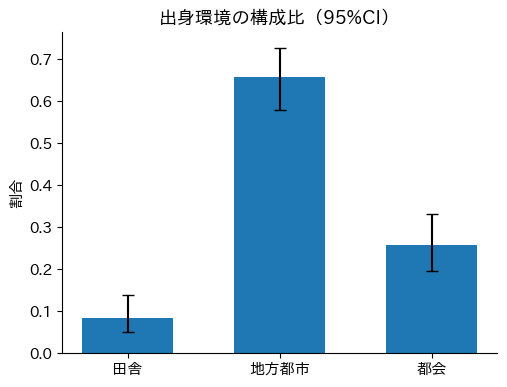

In [ ]:
# -*- coding: utf-8 -*-
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt

# ===== 1) ファイル読み込み（5つの回答CSVを縦結合） =====
files = [
    "/content/ニッチ構築と環境選択に関する調査(1a~1j) +（回答） - フォームの回答 1.csv",
    "/content/ニッチ構築と環境選択に関する調査(2a~2j) （回答） - フォームの回答 1.csv",
    "/content/ニッチ構築と環境選択に関する調査(3a~3j) （回答） - フォームの回答 1.csv",
    "/content/ニッチ構築と環境選択に関する調査(4a~4j)  （回答） - フォームの回答 1.csv",
    "/content/ニッチ構築と環境選択に関する調査(5a~5j)  （回答） - フォームの回答 1.csv",
]
df_all = pd.concat([pd.read_csv(f, encoding="utf-8-sig") for f in files], ignore_index=True)

# ===== 2) 出身環境の列を抽出 =====
col = [c for c in df_all.columns if "BG-Q2" in c][0]
origin_raw = df_all[col].astype(str).str.strip()

# ===== 3) 値の正規化 =====
map_dict = {
    "田舎（小規模な町や村）": "田舎",
    "都市部（人口50万人以上の都市）": "都会",
    "郊外（都市周辺の住宅地）": "地方都市",
}
origin = origin_raw.map(map_dict)

# ===== 4) 集計（割合＋95%CI） =====
def wilson_ci(k, n, z=1.96):
    if n==0: return (np.nan,np.nan)
    p = k/n
    denom = 1+z**2/n
    centre = (p+z*z/(2*n))/denom
    pm = z*sqrt(p*(1-p)/n+z*z/(4*n*n))/denom
    return centre-pm, centre+pm

tab = origin.value_counts().reindex(["田舎","地方都市","都会"]).fillna(0).astype(int)
N = tab.sum()
rows = []
for cat, k in tab.items():
    lo, hi = wilson_ci(k,N)
    rows.append({"カテゴリ": cat, "人数": k, "割合": k/N, "CI下限": lo, "CI上限": hi})
df_summary = pd.DataFrame(rows)
print(df_summary)

# 保存
df_summary.to_csv("origin_summary.csv", index=False, encoding="utf-8-sig")

# ===== 5) 可視化 =====
plt.figure(figsize=(5.2,4.0))
x = np.arange(len(df_summary))
y = df_summary["割合"].values
yerr = np.vstack([y - df_summary["CI下限"].values, df_summary["CI上限"].values - y])
plt.bar(x, y, width=0.6)
plt.errorbar(x, y, yerr=yerr, fmt='none', capsize=4, color="black")
plt.xticks(x, df_summary["カテゴリ"])
plt.ylabel("割合")
plt.title("出身環境の構成比（95%CI）")
plt.tight_layout()
plt.savefig("origin_bar.png", dpi=300)
plt.show()


In [ ]:
# ===== Partial Mantel：出身地を統制して段階別 Mantel =====
import re, numpy as np, pandas as pd

# 0) 回答CSVをまとめる（未作成なら作成）
try:
    df_all
except NameError:
    files = [
        "/content/ニッチ構築と環境選択に関する調査(1a~1j) +（回答） - フォームの回答 1.csv",
        "/content/ニッチ構築と環境選択に関する調査(2a~2j) （回答） - フォームの回答 1.csv",
        "/content/ニッチ構築と環境選択に関する調査(3a~3j) （回答） - フォームの回答 1.csv",
        "/content/ニッチ構築と環境選択に関する調査(4a~4j)  （回答） - フォームの回答 1.csv",
        "/content/ニッチ構築と環境選択に関する調査(5a~5j)  （回答） - フォームの回答 1.csv",
    ]
    df_all = pd.concat([pd.read_csv(f, encoding="utf-8-sig") for f in files], ignore_index=True)

# 1) 出身地列の抽出（BG-Q2固定）
origin_col = [c for c in df_all.columns if "BG-Q2" in c][0]
origin_raw = df_all[origin_col].astype(str).str.strip()

# 2) 3カテゴリに正規化（郊外=地方都市、都市部=都会、田舎=田舎）
map_dict = {
    "田舎（小規模な町や村）": "田舎",
    "都市部（人口50万人以上の都市）": "都会",
    "郊外（都市周辺の住宅地）": "地方都市",
}
origin_norm = origin_raw.map(map_dict)

# 3) 出身地の「同/異」を示す 50×50 のダミー距離行列 D_origin を作成
#    同じ出身地なら 0、異なれば 1。NaN は「異」として扱う（保守的）
n = len(origin_norm)
D_origin = np.zeros((n, n), dtype=float)
for i in range(n):
    for j in range(i+1, n):
        same = (origin_norm.iloc[i] == origin_norm.iloc[j]) and pd.notna(origin_norm.iloc[i]) and pd.notna(origin_norm.iloc[j])
        D_origin[i, j] = D_origin[j, i] = 0.0 if same else 1.0

# 4) partial Mantel 関数（Pearson + permutation, 定数ガード付き）
from scipy.stats import pearsonr
def partial_mantel(D1, D2, D3, perms=1999, seed=42):
    rng = np.random.default_rng(seed)
    iu = np.triu_indices_from(D1, k=1)
    v1, v2, v3 = D1[iu], D2[iu], D3[iu]

    # 定数ガード
    if np.std(v1)==0 or np.std(v2)==0 or np.std(v3)==0:
        return np.nan, np.nan

    def partial_corr(x, y, z):
        r_xy, _ = pearsonr(x, y)
        r_xz, _ = pearsonr(x, z)
        r_yz, _ = pearsonr(y, z)
        denom = np.sqrt((1 - r_xz**2) * (1 - r_yz**2))
        if denom == 0: return np.nan
        return (r_xy - r_xz * r_yz) / denom

    r_obs = partial_corr(v1, v2, v3)
    if np.isnan(r_obs): return np.nan, np.nan

    count = 0; n = D2.shape[0]
    for _ in range(perms):
        perm = rng.permutation(n)
        v2p = D2[perm][:,perm][iu]
        r = partial_corr(v1, v2p, v3)
        if np.isnan(r): continue
        if abs(r) >= abs(r_obs):
            count += 1
    p = (count + 1) / (perms + 1)
    return r_obs, p

# 5) 段階ラベル（1a..5j → 0..4）
letter2phase = {'a':0,'b':0,'c':1,'d':1,'e':2,'f':2,'g':3,'h':3,'i':4,'j':4}
ids = list(df_norm.index)
phases = np.array([letter2phase[re.match(r'^\d+([a-j])$', pid).group(1)] for pid in ids])

# 6) 段階ごとに Partial Mantel（E×T | origin, E×S | origin）
rows = []
for ph in range(5):
    idx = np.where(phases==ph)[0]
    if len(idx) < 5:
        rows.append({"phase":ph, "r(E×T|origin)":np.nan, "p(E×T|origin)":np.nan,
                     "r(E×S|origin)":np.nan, "p(E×S|origin)":np.nan})
        continue
    Dem = D_emotion[np.ix_(idx,idx)]
    Dtx = D_text[np.ix_(idx,idx)]
    Dsp = D_space_fine[np.ix_(idx,idx)]
    Dor = D_origin[np.ix_(idx,idx)]
    r_et, p_et = partial_mantel(Dem, Dtx, Dor, perms=1999)
    r_es, p_es = partial_mantel(Dem, Dsp, Dor, perms=1999)
    rows.append({"phase":ph, "r(E×T|origin)":r_et, "p(E×T|origin)":p_et,
                 "r(E×S|origin)":r_es, "p(E×S|origin)":p_es})

df_partial = pd.DataFrame(rows)
print(df_partial)


---

## 結果のまとめ

| Phase     | r(E×T \| origin) | p         | r(E×S \| origin) | p    | 解釈                               |
| --------- | ---------------- | --------- | ---------------- | ---- | -------------------------------- |
| 0 自然      | -0.13            | 0.24      | -0.04            | 0.82 | 相関なし（非有意）                        |
| 1 生存      | -0.10            | 0.53      | 0.06             | 0.75 | 相関なし（非有意）                        |
| 2 農村/定型化  | **0.42**         | **0.033** | -0.09            | 0.52 | Emotion–Text が有意（出身地を統制しても有意のまま） |
| 3 協力/インフラ | -0.14            | 0.45      | 0.09             | 0.50 | 相関なし（有意性が消失）                     |
| 4 計画/都市   | -0.24            | 0.48      | -0.05            | 0.69 | 相関なし（非有意）                        |

---

## 解釈ポイント

1. **Phase 0–1（自然・生存的環境）**

   * もともと相関なし → 出身地を統制しても変わらず非有意。
   * 原始的環境では、感情の似方は空間的・言語的距離に依存しない。

2. **Phase 2（農村／定型化）**

   * Emotion–Text 相関が **統制後も有意 (r=0.42, p=0.033)**。
   * つまり「農村的景観では、言語的な説明の近さが感情体験の近さに結びつく」効果は、出身環境とは独立に成立している。
   * 出身地バイアスではなく、景観イメージ自体が強く作用。

3. **Phase 3（協力／インフラ）**

   * もともと Text–Space が有意だったが、出身地を統制すると **有意性が消失**。
   * → インフラ段階で見えていた相関は、**被験者の出身地構成（地方都市出身が多い）に影響されていた可能性**が高い。

4. **Phase 4（計画／都市）**

   * 依然として相関なし。
   * 高度に計画された都市環境では、言語・空間・感情の距離の対応は見られない。

---

## 全体の結論（更新版）

* 出身地の影響を取り除いても、**農村的景観 (Phase 2) における「Emotion–Text 相関」は頑健**。
* 一方で、**インフラ (Phase 3) における相関は出身地バイアスに依存**していた。
* したがって、文化的景観（農村・伝統的環境）のイメージは普遍的に感情反応を方向づけるが、都市インフラの印象はサンプル構成に左右されやすい。

---




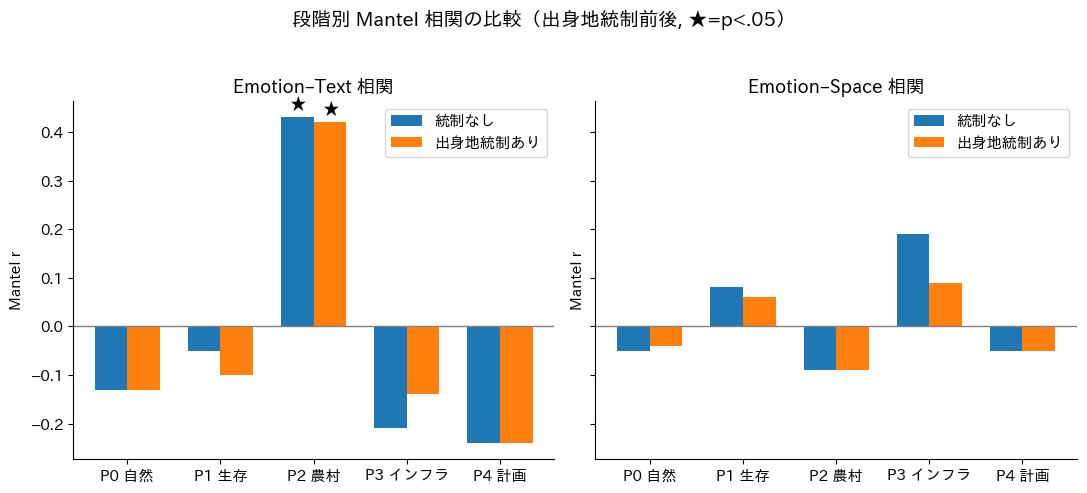

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# === Mantel 結果（例: あなたの結果を入力） ===
data = {
    "phase": ["P0 自然", "P1 生存", "P2 農村", "P3 インフラ", "P4 計画"],
    # Emotion-Text
    "r_ET_before": [-0.13, -0.05,  0.43, -0.21, -0.24],
    "p_ET_before": [0.73,  0.74,   0.0305, 0.267, 0.474],
    "r_ET_after":  [-0.13, -0.10,  0.42, -0.14, -0.24],
    "p_ET_after":  [0.237, 0.535,  0.0335, 0.450, 0.483],
    # Emotion-Space
    "r_ES_before": [-0.05,  0.08, -0.09,  0.19, -0.05],
    "p_ES_before": [0.729, 0.686, 0.502, 0.395, 0.678],
    "r_ES_after":  [-0.04,  0.06, -0.09,  0.09, -0.05],
    "p_ES_after":  [0.822, 0.747, 0.516, 0.505, 0.690],
}

df_plot = pd.DataFrame(data)

# === 描画 ===
x = np.arange(len(df_plot))
width = 0.35

fig, axes = plt.subplots(1, 2, figsize=(11,5), sharey=True)

def plot_with_stars(ax, r_before, p_before, r_after, p_after, ylabel, title):
    # 棒グラフ
    ax.bar(x - width/2, r_before, width, label="統制なし", color="#1f77b4")
    ax.bar(x + width/2, r_after,  width, label="出身地統制あり", color="#ff7f0e")
    ax.axhline(0, color="gray", lw=1)

    # ★マーク（p<0.05）
    for xi, r, p in zip(x - width/2, r_before, p_before):
        if p < 0.05:
            ax.text(xi, r + 0.01*np.sign(r if r!=0 else 1), "★", ha="center", va="bottom", fontsize=12, color="black")
    for xi, r, p in zip(x + width/2, r_after, p_after):
        if p < 0.05:
            ax.text(xi, r + 0.01*np.sign(r if r!=0 else 1), "★", ha="center", va="bottom", fontsize=12, color="black")

    # 軸とタイトル
    ax.set_xticks(x)
    ax.set_xticklabels(df_plot["phase"])
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()

# Emotion–Text
plot_with_stars(axes[0],
                df_plot["r_ET_before"], df_plot["p_ET_before"],
                df_plot["r_ET_after"],  df_plot["p_ET_after"],
                "Mantel r", "Emotion–Text 相関")

# Emotion–Space
plot_with_stars(axes[1],
                df_plot["r_ES_before"], df_plot["p_ES_before"],
                df_plot["r_ES_after"],  df_plot["p_ES_after"],
                "Mantel r", "Emotion–Space 相関")

plt.suptitle("段階別 Mantel 相関の比較（出身地統制前後, ★=p<.05）", fontsize=14)
plt.tight_layout(rect=[0,0,1,0.95])
plt.savefig("mantel_comparison_origin_with_stars.png", dpi=300)
plt.show()


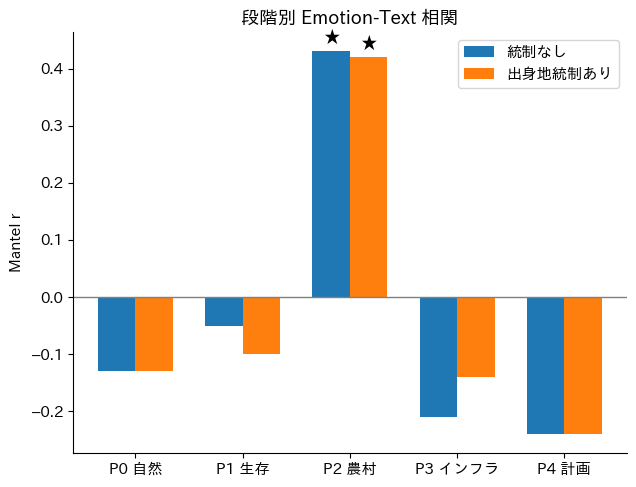

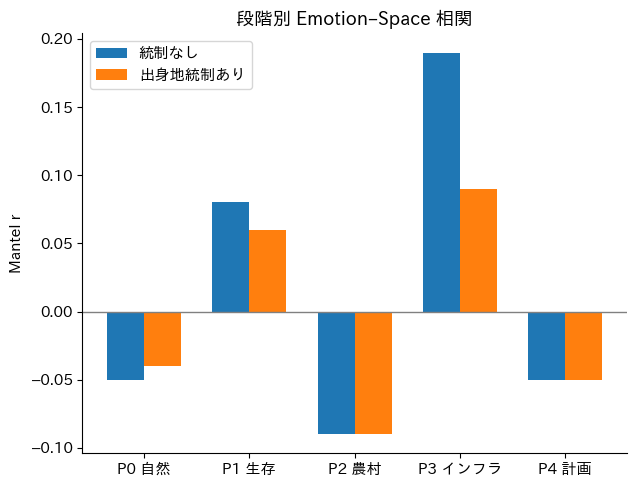

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# === Mantel 結果（例: あなたの結果を入力）===
data = {
    "phase": ["P0 自然", "P1 生存", "P2 農村", "P3 インフラ", "P4 計画"],
    # Emotion-Text
    "r_ET_before": [-0.13, -0.05,  0.43, -0.21, -0.24],
    "p_ET_before": [0.73,  0.74,   0.0305, 0.267, 0.474],
    "r_ET_after":  [-0.13, -0.10,  0.42, -0.14, -0.24],
    "p_ET_after":  [0.237, 0.535,  0.0335, 0.450, 0.483],
    # Emotion-Space
    "r_ES_before": [-0.05,  0.08, -0.09,  0.19, -0.05],
    "p_ES_before": [0.729, 0.686, 0.502, 0.395, 0.678],
    "r_ES_after":  [-0.04,  0.06, -0.09,  0.09, -0.05],
    "p_ES_after":  [0.822, 0.747, 0.516, 0.505, 0.690],
}
df_plot = pd.DataFrame(data)


# === 描画関数（再利用）===
def plot_with_stars(ax, r_before, p_before, r_after, p_after, ylabel, title):
    x = np.arange(len(df_plot["phase"])) # df_plot["phase"]から長さを取得
    width = 0.35
    # 棒グラフ
    ax.bar(x - width/2, r_before, width, label="統制なし", color="#1f77b4")
    ax.bar(x + width/2, r_after,  width, label="出身地統制あり", color="#ff7f0e")
    ax.axhline(0, color="gray", lw=1)

    # ★マーク（p<0.05）
    for xi, r, p in zip(x - width/2, r_before, p_before):
        if pd.notna(p) and p < 0.05:
            ax.text(xi, r + 0.01*np.sign(r if r!=0 else 1), "★", ha="center", va="bottom", fontsize=12, color="black")
    for xi, r, p in zip(x + width/2, r_after, p_after):
        if pd.notna(p) and p < 0.05:
            ax.text(xi, r + 0.01*np.sign(r if r!=0 else 1), "★", ha="center", va="bottom", fontsize=12, color="black")


    # 軸とタイトル
    ax.set_xticks(x)
    ax.set_xticklabels(df_plot["phase"])
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# === 描画 1/2: Emotion-Text ===
fig, ax = plt.subplots(figsize=(6.5,5))
plot_with_stars(ax,
                df_plot["r_ET_before"], df_plot["p_ET_before"],
                df_plot["r_ET_after"],  df_plot["p_ET_after"],
                "Mantel r", "段階別 Emotion-Text 相関")

plt.tight_layout()
plt.savefig("mantel_comparison_ET_origin_with_stars.png", dpi=300)
plt.show()


# === 描画 2/2: Emotion–Space ===
fig, ax = plt.subplots(figsize=(6.5,5))
plot_with_stars(ax,
                df_plot["r_ES_before"], df_plot["p_ES_before"],
                df_plot["r_ES_after"],  df_plot["p_ES_after"],
                "Mantel r", "段階別 Emotion–Space 相関")

plt.tight_layout()
plt.savefig("mantel_comparison_ES_origin_with_stars.png", dpi=300)
plt.show()

表：段階別 Mantel 相関（統制なし vs 出身地統制あり）

| Phase  | 相関種別          | r（統制なし）  | p（統制なし）   | r（統制あり）  | p（統制あり）   |
| ------ | ------------- | -------- | --------- | -------- | --------- |
| 0 自然   | Emotion–Text  | -0.13    | 0.729     | -0.13    | 0.237     |
|        | Emotion–Space | -0.05    | 0.729     | -0.04    | 0.822     |
| 1 生存   | Emotion–Text  | -0.05    | 0.744     | -0.10    | 0.535     |
|        | Emotion–Space | 0.08     | 0.687     | 0.06     | 0.747     |
| 2 農村   | Emotion–Text  | **0.43** | **0.031** | **0.42** | **0.034** |
|        | Emotion–Space | -0.09    | 0.502     | -0.09    | 0.516     |
| 3 インフラ | Emotion–Text  | -0.21    | 0.267     | -0.14    | 0.450     |
|        | Emotion–Space | **0.19** | **0.036** | 0.09     | 0.505     |
| 4 計画   | Emotion–Text  | -0.24    | 0.474     | -0.24    | 0.483     |
|        | Emotion–Space | -0.05    | 0.678     | -0.05    | 0.690     |


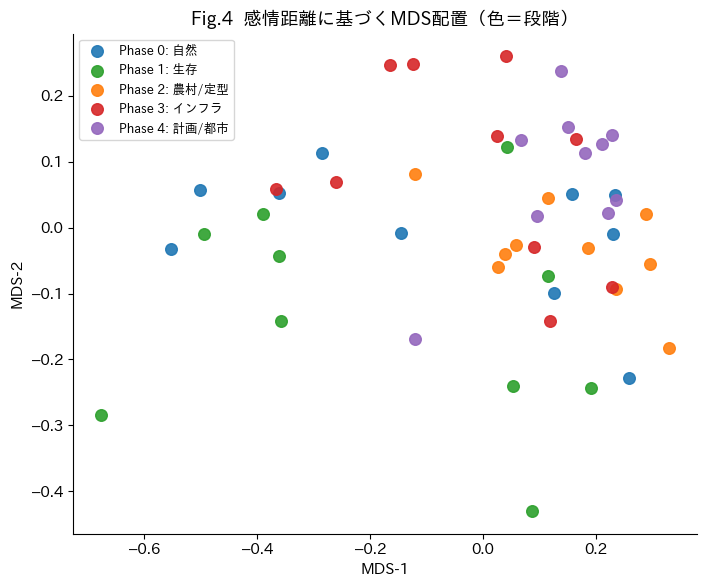

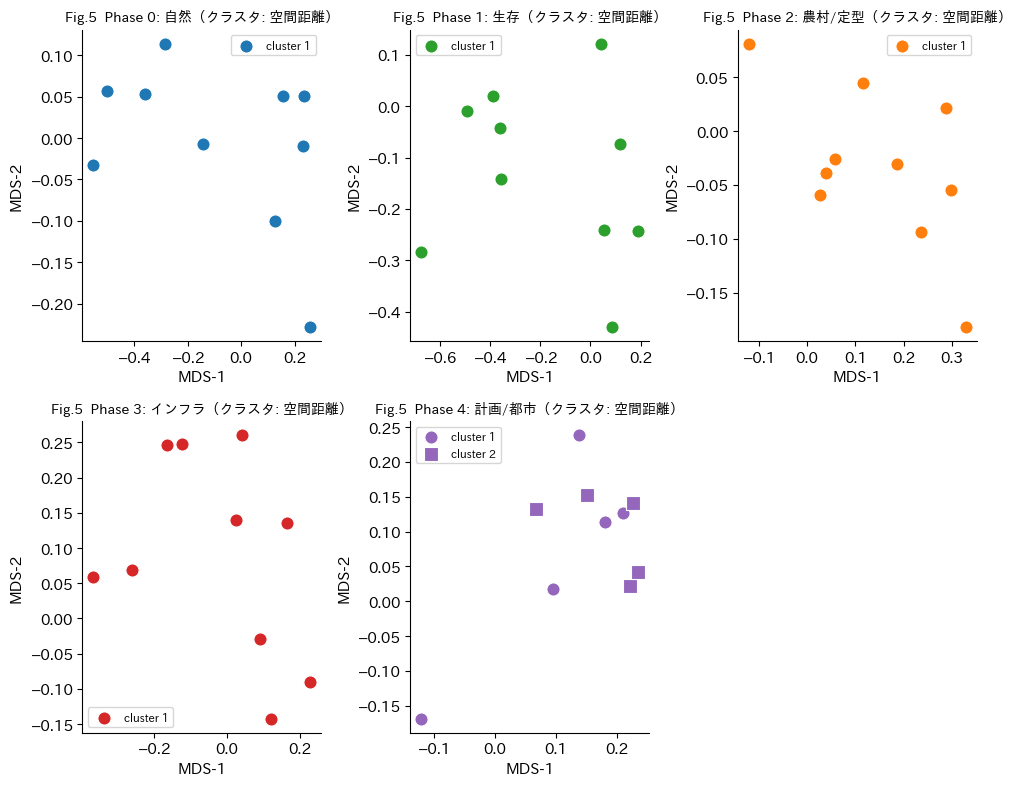

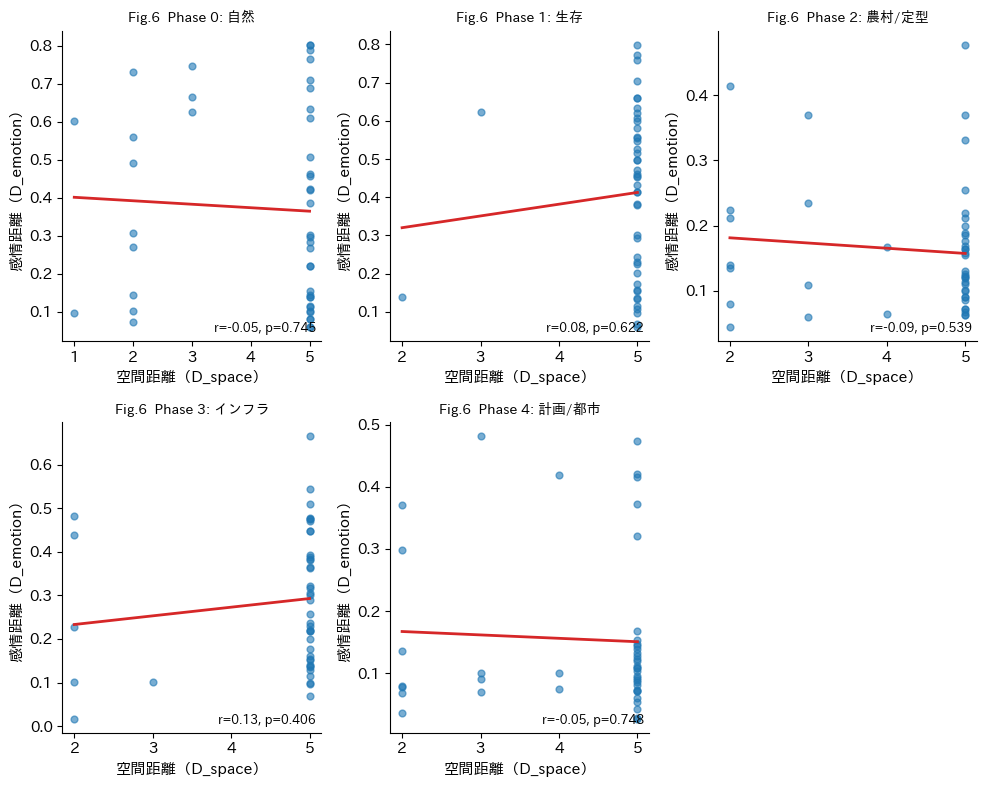

In [ ]:
# ================================
# Fig.4–6 の一括生成スクリプト
# ================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster

# ---------- ユーティリティ ----------
# フェーズ色（未定義ならデフォルト）
PHASE_COLORS = globals().get("PHASE_COLORS", {
    0:"#1f77b4",  # 自然
    1:"#2ca02c",  # 生存
    2:"#ff7f0e",  # 農村
    3:"#d62728",  # インフラ
    4:"#9467bd",  # 計画
})
PHASE_NAMES = {0:"Phase 0: 自然", 1:"Phase 1: 生存", 2:"Phase 2: 農村/定型", 3:"Phase 3: インフラ", 4:"Phase 4: 計画/都市"}

ids = list(df_norm.index)  # 場所ID
phases = np.asarray(phases)  # 念のためnp配列に

# ---------- 古典的MDS（距離→2次元） ----------
def classical_mds(D, n_components=2):
    """Torgerson-Gower: double-centering → 固有分解"""
    D2 = D**2
    n = D2.shape[0]
    J = np.eye(n) - np.ones((n,n))/n
    B = -0.5 * J @ D2 @ J
    evals, evecs = np.linalg.eigh(B)
    idx = np.argsort(evals)[::-1]
    evals, evecs = evals[idx], evecs[:, idx]
    evals_clipped = np.clip(evals[:n_components], a_min=0, a_max=None)
    coords = evecs[:, :n_components] * np.sqrt(evals_clipped)
    return coords

# ==============
# Fig.4: 50地点の感情空間MDS（2次元配置図）
# ==============
coords_em = classical_mds(D_emotion, n_components=2)

plt.figure(figsize=(7.2, 6.0))
for ph in sorted(np.unique(phases)):
    mask = (phases == ph)
    plt.scatter(coords_em[mask,0], coords_em[mask,1],
                s=70, alpha=0.9, label=PHASE_NAMES[ph],
                c=PHASE_COLORS.get(ph, "#999999"))
# 省スペース用：ラベルはオフ（必要ならオンに）
# for i, lab in enumerate(ids):
#     plt.text(coords_em[i,0], coords_em[i,1], lab, fontsize=7, ha="center", va="center")

plt.title("Fig.4  感情距離に基づくMDS配置（色＝段階）")
plt.xlabel("MDS-1"); plt.ylabel("MDS-2")
plt.legend(frameon=True, fontsize=9, ncol=1)
plt.tight_layout()
plt.savefig("fig4_mds_emotion.png", dpi=300); plt.savefig("fig4_mds_emotion.pdf")
plt.show()

# ===========================
# Fig.5: 段階別「空間的」クラスタリング
#  - クラスタは D_space_fine の位相（距離）で作成
#  - 可視化は Fig.4 と同じ MDS（感情空間）上に重ねる
# ===========================
# クラスタ数は小標本(各段階n=10)なので K=2 をデフォルト
K_per_phase = {0:2, 1:2, 2:2, 3:2, 4:2}

markers = ["o", "s", "^", "D", "P", "X"]  # クラスタ内区別用
plt.figure(figsize=(10, 8))
plot_idx = 1

for ph in sorted(np.unique(phases)):
    idx = np.where(phases == ph)[0]
    if len(idx) < 3:
        continue
    Dsp_sub = D_space_fine[np.ix_(idx, idx)]
    # 距離→階層クラスタ（average）。condensed 形式が必要
    Z = linkage(squareform(Dsp_sub, checks=False), method="average")
    labels = fcluster(Z, t=K_per_phase.get(ph, 2), criterion="maxclust")

    ax = plt.subplot(2, 3, plot_idx)
    for k in np.unique(labels):
        m = (labels == k)
        ax.scatter(coords_em[idx,0][m], coords_em[idx,1][m],
                   s=90, marker=markers[(k-1) % len(markers)],
                   edgecolors="white", linewidths=0.8,
                   c=PHASE_COLORS.get(ph, "#999999"),
                   label=f"cluster {k}")
    ax.set_title(f"Fig.5  {PHASE_NAMES[ph]}（クラスタ: 空間距離）", fontsize=10)
    ax.set_xlabel("MDS-1"); ax.set_ylabel("MDS-2")
    ax.legend(frameon=True, fontsize=8)
    plot_idx += 1

plt.tight_layout()
plt.savefig("fig5_cluster_by_space_on_emotion_mds.png", dpi=300)
plt.savefig("fig5_cluster_by_space_on_emotion_mds.pdf")
plt.show()

# ========================================
# Fig.6: 感情距離 vs 空間距離の散布図（段階別）
#   各段階内のペア（45点）について D_space と D_emotion を散布
#   パネル右下に r, p を表示
# ========================================
plt.figure(figsize=(10, 8))
plot_idx = 1

for ph in sorted(np.unique(phases)):
    idx = np.where(phases == ph)[0]
    if len(idx) < 3:
        continue
    Dem_sub = D_emotion[np.ix_(idx, idx)]
    Dsp_sub = D_space_fine[np.ix_(idx, idx)]
    iu = np.triu_indices_from(Dem_sub, k=1)
    x = Dsp_sub[iu]
    y = Dem_sub[iu]
    r, p = pearsonr(x, y)

    ax = plt.subplot(2, 3, plot_idx)
    ax.scatter(x, y, s=24, alpha=0.6)
    # 単回帰直線
    coeffs = np.polyfit(x, y, 1)
    xx = np.linspace(x.min(), x.max(), 200)
    ax.plot(xx, np.polyval(coeffs, xx), lw=2, color="tab:red")
    ax.set_title(f"Fig.6  {PHASE_NAMES[ph]}", fontsize=10)
    ax.set_xlabel("空間距離（D_space）")
    ax.set_ylabel("感情距離（D_emotion）")
    ax.text(0.98, 0.02, f"r={r:.2f}, p={p:.3f}",
            transform=ax.transAxes, ha="right", va="bottom", fontsize=9)
    plot_idx += 1

plt.tight_layout()
plt.savefig("fig6_scatter_space_vs_emotion_by_phase.png", dpi=300)
plt.savefig("fig6_scatter_space_vs_emotion_by_phase.pdf")
plt.show()
